# PAM GtACR1, starved flies

In [1]:
import numpy as np
import os
import time
import scipy
import glob
import sys
from datetime import datetime
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib
import pandas as pd
import scipy.stats as spstats

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import plotting as putil
import google_drive as gdrive

from matplotlib.gridspec import GridSpec

import matplotlib.gridspec as gridspec
import stats as st

import trajectory as traj

In [2]:
importlib.reload(util)
util.set_sns_style(style='dark')
%matplotlib notebook

In [3]:
# if util.get_os() == 'Linux':
#     rootdir = '/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data'
# elif util.get_os() == 'Darwin':
#     rootdir = '/home/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
# else:
#     rootdir=None
#     print("Unknown os: {}".format(util.get_os()))
rootdir = util.get_rootdir()
experiment = 'PAM_GtACR1'

src_dir = os.path.join(rootdir, experiment)
# # src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
# print(src_dir)
fig_id = os.path.join('/Edge_Tracking', rootdir.split('/Edge_Tracking/')[1], experiment)
print(fig_id)
savedir = '{}/jyr/{}'.format(rootdir, experiment)
savedir = savedir.replace(" ", "")
figdir = os.path.join(savedir, 'figures')
print("Saving figures to:{}    {}".format('\n', figdir))
if not os.path.exists(figdir):
    os.makedirs(figdir)

/Edge_Tracking/Data/PAM_GtACR1
Saving figures to:
    /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures


In [4]:
select_logs = [
    '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log',
    '10292021-143856_PAMGTACR1_thresh_lights_LT_Fly2_003.log',
    '11102021_Fly1/11102021-104614_PAMGtACR1_thresh_lights_old_food_yeast_Fly1_001.log',
    '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002.log',
    '11102021-134854_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_001.log',
    '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11152021-150321_PAMGtACR1_Fly1_002.log',
    '11152021-153105_PAMGtACR1_Fly1_003.log',
    '11162021-104332_PAMGTACR1_Fly1_001.log',
    '11162021-105012_PAMGtACR1_Fly1_002.log',
]

In [5]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [6]:
importlib.reload(gdrive)

<module 'google_drive' from '/home/julianarhee/Repositories/plume-tracking/google_drive.py'>

#### GtACR1 has specified files from Andy

In [9]:
print(experiment)
loginfo_fpath = os.path.join(savedir, 'info.pkl')

if os.path.exists(loginfo_fpath):
    logdf = gdrive.load_gdrive_df(loginfo_fpath)
else:
    logdf = gdrive.get_info_from_gsheet(experiment)
logdf.shape

PAM_GtACR1


(62, 6)

In [10]:
logdf.head()

,fly,date,experiment,log,mfc,filepath
0,1,20211026,inside,10262021-113334_PAMGtACR1_thresh_lights_on_Fly...,new,/home/julianarhee/edgetracking-googledrive/Edg...
1,1,20211026,none,10262021-114313_PAMGTACR1_thresh_no_lights_Fly...,new,/home/julianarhee/edgetracking-googledrive/Edg...
2,1,20211026,outisde,10262021-120011_PAMGtACR1_lights_outside_Fly1_...,new,/home/julianarhee/edgetracking-googledrive/Edg...
3,1,20211026,none,10262021-125040_PAMGtACR1_no_lights_strip.log,new,/home/julianarhee/edgetracking-googledrive/Edg...
4,2,20211027,none,10272021-150422_PAMGtACR1_no_lights_Fly1_001.log,new,/home/julianarhee/edgetracking-googledrive/Edg...


## safe copy to my folder

In [11]:
copy_files=False
# -------------------------------------------------------------------------
if copy_files:
    import shutil
    if not os.path.exists(os.path.join(savedir, 'raw')):
        os.makedirs(os.path.join(savedir, 'raw'))
    for fpath in logdf['filepath'].values:
        fbase = os.path.split(fpath)[-1]
        shutil.copy(fpath, os.path.join(savedir, 'raw', fbase))

src_dir = os.path.join(savedir, 'raw')
len(sorted(os.listdir(src_dir), key=util.natsort))


64

## get filepaths to raw log

In [12]:
if 'filepath' not in logdf.columns:
    print("Finding filepaths...")
    logdf['filepath'] = None
    #curr_fns = logdf[logdf['experiment']=='inside']['log'].values
    curr_fns = logdf['log'].values
    for fn in curr_fns:
        found_files=[]
        print(fn)
        try:
            found_files = glob.glob(os.path.join(src_dir, '*/*/{}'.format(fn)))
            assert len(found_files)==1, "No file found, checking one dir up."
        except AssertionError as e:
            found_files = glob.glob(os.path.join(src_dir, '*/{}'.format(fn)))
            assert len(found_files)==1, "No file found: {}.".format(fn)
        if len(found_files)==1:
            logdf.loc[logdf['log']==fn, 'filepath'] = found_files[0] 

    # save
    import _pickle as pkl
    gdrive.save_gdrive_df(logdf, loginfo_fpath)


## check LED activation inside/outside

In [13]:
check_leds = False
if check_leds:
    fn = '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log'
    fpath = os.path.join(src_dir, fn)
    df0 = pd.read_csv(fpath, encoding='latin' )
    df_ = butil.load_dataframe(fpath, experiment=experiment)
    df_ = butil.correct_manual_conditions(df_, experiment, logdf=logdf)
    df_ = butil.process_df(df_)
    print(df0.columns)

    fig, axn = pl.subplots(1,3)
    sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
    sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

    fig, axn = pl.subplots(1,3)
    sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
    sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
    sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='led_on', ax=axn[2],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

# Get combined df

In [55]:
create_new=True
strip_width=50
strip_sep=1000
# ---------------------------------
log_files = butil.get_log_files(src_dir=src_dir, experiment=experiment, verbose=False, is_gdrive=False,
                        return_loginfo=False)
# is_csv = False
if not create_new:
    df_fpath = os.path.join(savedir, 'combined_df0.pkl')
    df0_all = butil.load_df(df_fpath)
else:
    df0_all = butil.load_combined_df(log_files=log_files, logdf=logdf, src_dir=src_dir,
                                is_csv=False, experiment=experiment, 
                                savedir=savedir, save_errors=False, create_new=create_new,
                                parse_filename=True, remove_invalid=True, process=True)
    #df0_all = df0_all.reset_index(drop=True)
    # Make some fixes
    df0_all.loc[df0_all['experiment']=='outisde', 'experiment'] = 'outside'
    df0_all.loc[df0_all['experiment']=='inisde', 'experiment'] = 'inside'
    df0_all.loc[df0_all['experiment']=='lights', 'experiment'] = 'inside'
    # 1 mistaken condition (based on LED activation pattern):
    df0_all.loc[df0_all['filename']=='10272021-164059_PAMGTACR1_thresh_lights_on_inside_LT_Fly1_009', 'experiment'] = 'outside'
    # assign lights ON or off for condition
    no_lights = [f for f in df0_all['condition'].unique() if 'no_lights' in f]
    lights = [f for f in df0_all['condition'].unique() if f not in no_lights]
    df0_all.loc[df0_all['condition'].isin(no_lights), 'condition'] = 'no_lights'
    df0_all.loc[df0_all['condition'].isin(lights), 'condition'] = 'lights'
    # make sure LED signal is OFF for these old files:
    df0_all.loc[df0_all['condition']=='no_lights', 'led_on'] = False
    df0_all.loc[df0_all['condition']=='no_lights', 'led1_stpt'] = 1
# exclude = [
#     '10262021-125040_PAMGtACR1_no_lights_strip', 
#     '10262021-120011_PAMGtACR1_lights_outside_Fly1_003',
#     '11162021-161133_PAMGtACR1_Fly3_006', 
#     '11122021-165711_PAMGtACR1_Fly1_008'
# ]
# df0_all = df0_all[~df0_all['filename'].isin(exclude)]

condition_list = df0_all['condition'].unique()
print("Found {} conditions:".format(len(condition_list)))
for c in condition_list:
    print(c)

if create_new: # save
    df_fpath = os.path.join(savedir, 'combined_df0.pkl')
    print("Saving combined df to: {}".format(savedir))
    butil.save_df(df0_all, df_fpath)
create_new=False

Checking parent dir.
Found 63 tracking files.
Processing 63 tracking files.
Creating combined df
[WARNING] ['10262021-113334_PAMGtACR1_thresh_lights_on_Fly1_001']: Found bad skips, removing 60 of 13907 samples.
[WARNING] ['10272021-160023_PAMGtACR1_thresh_lights_LT_early_Fly1_004']: Found bad skips, removing 8 of 5175 samples.
[WARNING] ['10272021-161524_PAM_GTACR1_thresh_lights_on_Fly1_007']: Found bad skips, removing 15738 of 21494 samples.
[WARNING] ['10272021-163421PAMGTACR1_thresh_lights_on_outside_LT_Fly1_008']: Found bad skips, removing 49 of 7499 samples.
[WARNING] ['10282021-141515_PAMGTACR1_thresh_lights_on_LT_Fly1_001']: Found bad skips, removing 2598 of 24612 samples.
[WARNING] ['10282021-160632_PAMGTACR1_thresh_lights_on_Fly2_003']: Found bad skips, removing 5561 of 18140 samples.
[WARNING] ['10292021-121350_PAMGtACR1_thresh_lights_wanders_off_LT_Fly1_002']: Found bad skips, removing 120 of 11918 samples.
[WARNING] ['10292021-140440_PAMGtACR1_thresh_lights_on_error_LT_Fly2

[bout 48]  too short outstrip, should be IN
[bout 50]  too short outstrip, should be IN
[bout 10]  too short outstrip, should be IN
[bout 11]  too short instrip, should be OUT
[bout 13]  too short instrip, should be OUT
[bout 18]  too short outstrip, should be IN
[bout 19]  too short instrip, should be OUT
[bout 21]  too short instrip, should be OUT
[bout 22]  too short outstrip, should be IN
[bout 24]  too short outstrip, should be IN
[bout 6]  too short outstrip, should be IN
[bout 7]  too short instrip, should be OUT
[bout 9]  too short instrip, should be OUT
[bout 3]  too short instrip, should be OUT
[bout 8]  too short outstrip, should be IN
[bout 9]  too short instrip, should be OUT
[bout 10]  too short outstrip, should be IN
[bout 17]  too short instrip, should be OUT
[bout 18]  too short outstrip, should be IN
[bout 19]  too short instrip, should be OUT
[bout 20]  too short outstrip, should be IN
[bout 21]  too short instrip, should be OUT
[bout 22]  too short outstrip, should 

[bout 10]  too short outstrip, should be IN
[bout 13]  too short instrip, should be OUT
[bout 14]  too short outstrip, should be IN
[bout 16]  too short outstrip, should be IN
[bout 17]  too short instrip, should be OUT
[bout 18]  too short outstrip, should be IN
[bout 20]  too short outstrip, should be IN
[bout 21]  too short instrip, should be OUT
[bout 23]  too short instrip, should be OUT
[bout 28]  too short outstrip, should be IN
[bout 30]  too short outstrip, should be IN
[bout 31]  too short instrip, should be OUT
[bout 45]  too short instrip, should be OUT
[bout 47]  too short instrip, should be OUT
[bout 51]  too short instrip, should be OUT
[bout 52]  too short outstrip, should be IN
[bout 53]  too short instrip, should be OUT
[bout 54]  too short outstrip, should be IN
[bout 55]  too short instrip, should be OUT
[bout 65]  too short instrip, should be OUT
[bout 66]  too short outstrip, should be IN
[bout 67]  too short instrip, should be OUT
[bout 77]  too short instrip, sh

[bout 10]  too short outstrip, should be IN
[bout 16]  too short outstrip, should be IN
[bout 22]  too short outstrip, should be IN
[bout 27]  too short instrip, should be OUT
[bout 28]  too short outstrip, should be IN
[bout 29]  too short instrip, should be OUT
[bout 30]  too short outstrip, should be IN
[bout 32]  too short outstrip, should be IN
[bout 33]  too short instrip, should be OUT
[bout 34]  too short outstrip, should be IN
[bout 35]  too short instrip, should be OUT
[bout 46]  too short outstrip, should be IN
[bout 47]  too short instrip, should be OUT
[bout 48]  too short outstrip, should be IN
[bout 21]  too short instrip, should be OUT
[bout 22]  too short outstrip, should be IN
[bout 24]  too short outstrip, should be IN
[bout 25]  too short instrip, should be OUT
[bout 36]  too short outstrip, should be IN
[bout 25]  too short instrip, should be OUT
[bout 26]  too short outstrip, should be IN
[bout 39]  too short instrip, should be OUT
[bout 40]  too short outstrip, s

[bout 5]  too short instrip, should be OUT
[bout 19]  too short instrip, should be OUT
[bout 20]  too short outstrip, should be IN
[bout 21]  too short instrip, should be OUT
[bout 24]  too short outstrip, should be IN
[bout 29]  too short instrip, should be OUT
[bout 42]  too short outstrip, should be IN
[bout 43]  too short instrip, should be OUT
[bout 44]  too short outstrip, should be IN
[bout 49]  too short instrip, should be OUT
[bout 50]  too short outstrip, should be IN
[bout 59]  too short instrip, should be OUT
[bout 60]  too short outstrip, should be IN
[bout 61]  too short instrip, should be OUT
[bout 66]  too short outstrip, should be IN
[bout 67]  too short instrip, should be OUT
[bout 80]  too short outstrip, should be IN
[bout 81]  too short instrip, should be OUT
[bout 82]  too short outstrip, should be IN
[bout 84]  too short outstrip, should be IN
[bout 85]  too short instrip, should be OUT
[bout 86]  too short outstrip, should be IN
[bout 94]  too short outstrip, sh

[bout 181]  too short instrip, should be OUT
[bout 182]  too short outstrip, should be IN
[bout 183]  too short instrip, should be OUT
[bout 189]  too short instrip, should be OUT
[bout 193]  too short instrip, should be OUT
[bout 194]  too short outstrip, should be IN
[bout 195]  too short instrip, should be OUT
[bout 196]  too short outstrip, should be IN
[bout 197]  too short instrip, should be OUT
[bout 198]  too short outstrip, should be IN
[bout 199]  too short instrip, should be OUT
[bout 200]  too short outstrip, should be IN
[bout 202]  too short outstrip, should be IN
[bout 205]  too short instrip, should be OUT
[bout 206]  too short outstrip, should be IN
[bout 208]  too short outstrip, should be IN
[bout 211]  too short instrip, should be OUT
[bout 215]  too short instrip, should be OUT
[bout 217]  too short instrip, should be OUT
[bout 218]  too short outstrip, should be IN
[bout 219]  too short instrip, should be OUT
[bout 220]  too short outstrip, should be IN
[bout 222]

[bout 90]  too short outstrip, should be IN
[bout 91]  too short instrip, should be OUT
[bout 7]  too short instrip, should be OUT
[bout 25]  too short instrip, should be OUT
[bout 38]  too short outstrip, should be IN
[bout 39]  too short instrip, should be OUT
[bout 51]  too short instrip, should be OUT
[bout 83]  too short instrip, should be OUT
[bout 7]  too short instrip, should be OUT
[bout 8]  too short outstrip, should be IN
[bout 9]  too short instrip, should be OUT
[bout 15]  too short instrip, should be OUT
[bout 37]  too short instrip, should be OUT
[bout 53]  too short instrip, should be OUT
[bout 54]  too short outstrip, should be IN
[bout 55]  too short instrip, should be OUT
[bout 57]  too short instrip, should be OUT
[bout 58]  too short outstrip, should be IN
[bout 60]  too short outstrip, should be IN
[bout 61]  too short instrip, should be OUT
[bout 67]  too short instrip, should be OUT
[bout 77]  too short instrip, should be OUT
[bout 83]  too short instrip, should

[bout 7]  too short instrip, should be OUT
[bout 11]  too short instrip, should be OUT
[bout 13]  too short instrip, should be OUT
[bout 17]  too short instrip, should be OUT
[bout 27]  too short instrip, should be OUT
[bout 4]  too short outstrip, should be IN
[bout 5]  too short instrip, should be OUT
[bout 6]  too short outstrip, should be IN
[bout 7]  too short instrip, should be OUT
[bout 11]  too short instrip, should be OUT
[bout 21]  too short instrip, should be OUT
[bout 22]  too short outstrip, should be IN
[bout 23]  too short instrip, should be OUT
[bout 24]  too short outstrip, should be IN
[bout 27]  too short instrip, should be OUT
[bout 29]  too short instrip, should be OUT
[bout 30]  too short outstrip, should be IN
[bout 31]  too short instrip, should be OUT
[bout 32]  too short outstrip, should be IN
[bout 33]  too short instrip, should be OUT
[bout 4]  too short outstrip, should be IN
[bout 5]  too short instrip, should be OUT
[bout 17]  too short instrip, should be

[bout 9]  too short instrip, should be OUT
[bout 84]  too short outstrip, should be IN
[bout 9]  too short instrip, should be OUT
[bout 10]  too short outstrip, should be IN
[bout 11]  too short instrip, should be OUT
[bout 12]  too short outstrip, should be IN
[bout 13]  too short instrip, should be OUT
[bout 21]  too short instrip, should be OUT
[bout 23]  too short instrip, should be OUT
[bout 9]  too short instrip, should be OUT
[bout 10]  too short outstrip, should be IN
[bout 11]  too short instrip, should be OUT
[bout 9]  too short instrip, should be OUT
[bout 4]  too short outstrip, should be IN
[bout 5]  too short instrip, should be OUT
[bout 6]  too short outstrip, should be IN
[bout 4]  too short outstrip, should be IN
[bout 15]  too short instrip, should be OUT
[bout 16]  too short outstrip, should be IN
[bout 17]  too short instrip, should be OUT
[bout 18]  too short outstrip, should be IN
[bout 19]  too short instrip, should be OUT
[bout 20]  too short outstrip, should be

In [71]:
print("There are {} unique fly IDs.".format(len(df0_all['fly_id'].unique())))
df0_all['fly_id'].unique()

There are 14 unique fly IDs.


array(['20211026-fly1', '20211027-fly2', '20211028-fly3', '20211028-fly4',
       '20211029-fly6', '20211029-fly5', '20211110-fly14',
       '20211110-fly13', '20211112-fly12', '20211115-fly11',
       '20211116-fly10', '20211116-fly8', '20211116-fly9',
       '20211118-fly7'], dtype=object)

In [72]:
included_conditions = 'all' #'selected':
# ----------------------------------------------------------------
# from andy:
select_logs = [
    '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log',
    '10292021-143856_PAMGTACR1_thresh_lights_LT_Fly2_003.log',
    '11102021_Fly1/11102021-104614_PAMGtACR1_thresh_lights_old_food_yeast_Fly1_001.log',
    '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002.log',
    '11102021-134854_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_001.log',
    '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11152021-150321_PAMGtACR1_Fly1_002.log',
    '11152021-153105_PAMGtACR1_Fly1_003.log',
    '11162021-104332_PAMGTACR1_Fly1_001.log',
    '11162021-105012_PAMGtACR1_Fly1_002.log',
]

# make output dirs for figures
if not os.path.exists(os.path.join(figdir, 'selected')):
    os.makedirs(os.path.join(figdir, 'selected'))
incl_logs = [os.path.splitext(f)[0] for f in select_logs]

if not os.path.exists(os.path.join(figdir, 'inside_lights')):
    os.makedirs(os.path.join(figdir, 'inside_lights'))
 
# select dataset
if included_conditions=='selected':    
    df = df0_all[df0_all['filename'].isin(incl_logs)].copy()
    curr_figdir = os.path.join(figdir, 'selected')
elif included_conditions == 'all':
    df = df0_all.copy()
    curr_figdir = os.path.join(figdir, 'all')
else:
    df = df0_all[df0_all['condition'].isin(['inside', 'lights'])].copy()
    curr_figdir = os.path.join(figdir, 'inside_lights')

if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/all


In [73]:
len(df['fly_id'].unique())

14

## also load new flies?

In [74]:
src_dir

'/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/raw'

In [75]:
print(src_dir)
new_logfiles = glob.glob(os.path.join(src_dir, 'new', '*.log'))
len(new_logfiles)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/raw


5

In [76]:
# is_csv = False
if not create_new:
    df1_fpath = os.path.join(savedir, 'combined_df1.pkl')
    df1_all = butil.load_df(df1_fpath)
else:
    print("creating new...")
    df1_all = butil.load_combined_df(log_files=new_logfiles, logdf=None, src_dir=src_dir,
                                is_csv=False, experiment=experiment, 
                                savedir=savedir, save_errors=False, create_new=True,
                                parse_filename=True, remove_invalid=True, process=True)
    # update condition info
    df1_all['led_on'] = df1_all['led1_stpt']==1
    df1_all['condition'] = 'lights'
    df1_all['experiment'] = 'inside'
    # df_ = df1_all[df1_all['fly_id']=='20230312-fly4'].copy()
    offset_y = df1_all.loc[(df1_all['fly_id']=='20230312-fly4') & (df1_all['instrip'])].iloc[0]['ft_posy']
    df1_all.loc[(df1_all['fly_id']=='20230312-fly4') & (df1_all['ft_posy']>=1000+offset_y), 'led_on']=False ## MANUAL LED OFF
    # save
    df1_fpath = os.path.join(savedir, 'combined_df1.pkl')
    butil.save_df(df1_all, df1_fpath)

df0_all.shape, df1_all.shape

((1177003, 40), (1079648, 45))

In [77]:
print(df0_all.shape)
print(df1_all.shape)

(1177003, 40)
(1079648, 45)


#### concate old and new

In [78]:
add_cols = [k for k in df1_all.columns if k not in df0_all.columns]
add_cols
same_cols = [k for k in df0_all.columns if k not in add_cols]

df0 = pd.concat([df0_all[df0_all['experiment']=='inside'], df1_all[same_cols]]).reset_index(drop=True)
print(df0.shape)

(2012182, 40)


In [79]:
cutoff_date = df1_all['date'].min() # dates BEFORE this date, led_on means led1_stpt=0; after, led_on means led1_stpt=1

# Assign trial epochs or blocks (i.e., led ON or OFF)

In [81]:
print(cutoff_date)

20230312


In [82]:
multi_block = ['11152021-160015_PAMGTACR1_Fly2_006',
              '11162021-104332_PAMGTACR1_Fly1_001',
              '11162021-105012_PAMGtACR1_Fly1_002',
               '11162021-110343_PAMGTACR1_Fly1_003',
              '11182021-123116_PAMGtACR1_Fly1_001',
               '20230312-142945_PAM_activation_fly4-PAM-GtACR1-2do-fastedvF_000',
               '20230312-162127_PAM_activation_fly5-PAM-GtACR1-2do-fastedF_002',
               '20230312-170057_PAM_activation_fly6-PAM-GtACR1-2do-fastedF_000'
              ]

In [481]:
#etdf = df_fp.copy().reset_index(drop=True)
df0['epoch'] = 'ledoff'
df0['block'] = None
for fn, df_ in df0.groupby('filename'):
    fpath = os.path.join(src_dir, 'new', '{}.log'.format(fn)) if fn.startswith('2023') else os.path.join(src_dir, '{}.log'.format(fn))
    cfg = butil.load_experiment_config(fpath)
    if cfg is None:
        y_thresh = 500
    else:
        print("found config")
        y_thresh = cfg['experiment']['y_thresh']
    y_thresh2 = y_thresh*2
    
    df_ = putil.zero_trajectory(df_)
    ypos_blocks = np.arange(0, df_['ft_posy'].max(), y_thresh)
    ledon_starts = ypos_blocks[1::2]
    for bi, thresh_val in enumerate(ypos_blocks):
        ts = df_.loc[  (df_['ft_posy']>=thresh_val) ].iloc[0]['rel_time']
        df_.loc[df_['rel_time']>=ts, 'block'] = bi
        if thresh_val in ledon_starts:
            #df_.loc[ (df_['ft_posy']>=thresh_val) & (df_['ft_posy']<(thresh_val+y_thresh)), 'epoch'] = 'ledon'
            df_.loc[ df_['block']==bi, 'epoch'] = 'ledon'
    # assign block IX to PRE-odor period
    ts = df_[df_['block']==0].iloc[0]['rel_time']
    df0.loc[ (df0['filename']==fn) & (df0['rel_time']<ts) , 'block'] = -1
    #print(fn, df_['block'].unique())
    df0.loc[df_.index, 'epoch'] = df_['epoch']
    df0.loc[df_.index, 'block'] = df_['block']
    # some files have LED on at ft_posy < 500... (but single value, rounding error, 499.99)
    if fn in ['11162021-110343_PAMGTACR1_Fly1_003','20230312-122906_PAM_activation_fly1-PAM-GtACR1-2do-fastedF_000', '10272021-161524_PAM_GTACR1_thresh_lights_on_Fly1_007']:
        df0.loc[ (df0['filename']==fn) & (df0['block']==0), 'led_on'] = False
        df0.loc[ (df0['filename']==fn) & (df0['block']==0), 'led1_stpt'] = 1
        
df0['bout_type'] = ['instrip' if i==1 else 'outstrip' for i in df0['instrip']]

found config
found config
found config
found config
found config


In [482]:
df0['block'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1], dtype=object)

# plot INSIDE activation

In [483]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

In [484]:
instrip_palette = {True: 'r', False: 'w'}
instrip_palette2 = {'instrip': 'r', 'outstrip': 'cornflowerblue'}

In [485]:
# exclude weird/unknown conditions:=
exclude = [
    '10262021-125040_PAMGtACR1_no_lights_strip', 
    '10262021-120011_PAMGtACR1_lights_outside_Fly1_003',
    '11162021-161133_PAMGtACR1_Fly3_006', 
    '11122021-165711_PAMGtACR1_Fly1_008'
]
df0 = df0[(~df0['filename'].isin(exclude))].copy()
df0 = df0.reset_index(drop=True)

example_flies = ['20211110-fly13', '20211115-fly11',  '20211110-fly13', '20230312-fly4']

In [486]:
plot_each = False
bool_colors = ['r', 'y']
bool_vars = ['instrip', 'led_on']
# ------------------------------------------------------------
if plot_each:
    curr_figdir = os.path.join(figdir, 'by-individual') #print(curr_figdir)
    if not os.path.exists(curr_figdir):
        os.makedirs(curr_figdir)
    print(curr_figdir)
    for fly_id, df_ in df0.groupby('fly_id'):
        fig = putil.plot_one_flys_trials(df_, sharey=False, sharex=True, bool_vars=bool_vars, bool_colors=bool_colors)
        pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.8)
        util.label_figure(fig, '{} - {}'.format(fig_id, fly_id))
        pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fly_id)))
        if fly_id in example_flies:
            pl.savefig(os.path.join(curr_figdir, '{}.svg'.format(fly_id)))

In [487]:
curr_figdir

'/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/ets'

# Find ETs (based on pre-LED)

In [488]:
curr_figdir = os.path.join(figdir, 'ets')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/ets


In [489]:
strip_width=50
strip_sep=1000
# max_crossovers = 0
# max_instrip_upwind_percent=0.5
# min_outside_bouts=5
max_crossovers = 0
max_instrip_upwind_percent=0.5
min_outside_bouts=5
min_global_upwind_dist=100
max_crossover_to_dist_ratio=1/500

et_flies={}
for fly_id, flydf in df0.groupby('fly_id'):
    print("****{}*****".format(fly_id))
    ets = []
    for trial_id, tmpdf in flydf.groupby('filename'):
        print("-- {} --".format(trial_id))
        if tmpdf[tmpdf['led_on']].shape[0]==0:
            continue
#         led_ix = tmpdf[tmpdf['led_on']].iloc[0].name
#         currdf = tmpdf.loc[0:led_ix].copy()
        last_bout_tmp = tmpdf[tmpdf['block']==0]['boutnum'].max()
        last_bout = last_bout_tmp if all(tmpdf[tmpdf['boutnum']==last_bout_tmp]['instrip']) else last_bout_tmp + 1
        currdf = tmpdf[tmpdf['boutnum'] <= last_bout].copy()
        odor_bounds = butil.find_strip_borders(currdf, 
                                            entry_ix=currdf[currdf['instrip']].iloc[0].name,
                                            strip_width=strip_width, strip_sep=strip_sep)
        et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(currdf,
                                    odor_bounds, strip_width=strip_width, strip_sep=strip_sep, 
                                    max_instrip_upwind_percent=max_instrip_upwind_percent, 
                                    max_crossovers=max_crossovers, 
                                    max_crossover_to_dist_ratio=max_crossover_to_dist_ratio,
                                    min_outside_bouts=min_outside_bouts,
                                    min_global_upwind_dist=min_global_upwind_dist)
        if len(et_bouts)>0:
            ets.append(trial_id)
    if len(ets)>0:
        et_flies.update({fly_id: ets})

****20211026-fly1*****
-- 10262021-113334_PAMGtACR1_thresh_lights_on_Fly1_001 --
not et: 0
****20211027-fly2*****
-- 10272021-154410_PAMGTACR1_thresh_lights_Fly1_003 --
Is ET: 0 True
-- 10272021-160023_PAMGtACR1_thresh_lights_LT_early_Fly1_004 --
Is ET: 0 True
-- 10272021-160508_PAMGTACR1_thresh_lights_on_Fly1_005 --
Is ET: 0 True
-- 10272021-161524_PAM_GTACR1_thresh_lights_on_Fly1_007 --
Is ET: 0 True
****20211028-fly3*****
-- 10282021-141515_PAMGTACR1_thresh_lights_on_LT_Fly1_001 --
Is ET: 0 True
-- 10282021-142840_PAMGtACR1_thresh_lights_on_Fly1_002 --
not et: 0
-- 10282021-151217_PAMGtACR1_thresh_Fly1_005 --
****20211028-fly4*****
-- 10282021-154004_PAMGTACR1_thresh_lights_on_Fly2_001 --
Is ET: 0 True
-- 10282021-155136_PAMGtACR1_thresh_lights_on_Fly2_002 --
not et: 0
-- 10282021-160632_PAMGTACR1_thresh_lights_on_Fly2_003 --
-- 10282021-161713_PAMGtACR1_thresh_lights_on_Fly2_004 --
****20211029-fly5*****
-- 10292021-140440_PAMGtACR1_thresh_lights_on_error_LT_Fly2_001 --
not et: 0
-

In [490]:
incl_files = util.flatten(et_flies.values())
print("Total: {} trajectories, across {} flies.".format(len(incl_files), len(et_flies.keys())))

etdf = df0[df0['filename'].isin(incl_files)].copy().reset_index(drop=True)
etdf = butil.correct_manual_conditions(etdf, logdf=logdf, verbose=False)
etdf.loc[etdf['date']<cutoff_date, 'led_on'] = etdf['led1_stpt'] == 0

Total: 29 trajectories, across 14 flies.
Correcting experiment conditions: None
Error with logdf: 20230312-122906_PAM_activation_fly1-PAM-GtACR1-2do-fastedF_000
index 0 is out of bounds for axis 0 with size 0
Error with logdf: 20230312-142945_PAM_activation_fly4-PAM-GtACR1-2do-fastedvF_000
index 0 is out of bounds for axis 0 with size 0
Error with logdf: 20230312-160222_PAM_activation_fly5-PAM-GtACR1-2do-fastedF_001
index 0 is out of bounds for axis 0 with size 0
Error with logdf: 20230312-162127_PAM_activation_fly5-PAM-GtACR1-2do-fastedF_002
index 0 is out of bounds for axis 0 with size 0
Error with logdf: 20230312-170057_PAM_activation_fly6-PAM-GtACR1-2do-fastedF_000
index 0 is out of bounds for axis 0 with size 0


In [491]:
etdf['filename'].nunique(), etdf['fly_id'].nunique()

(29, 14)

### plot all ET trajectories

In [492]:
curr_figdir

'/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/ets'

<IPython.core.display.Javascript object>


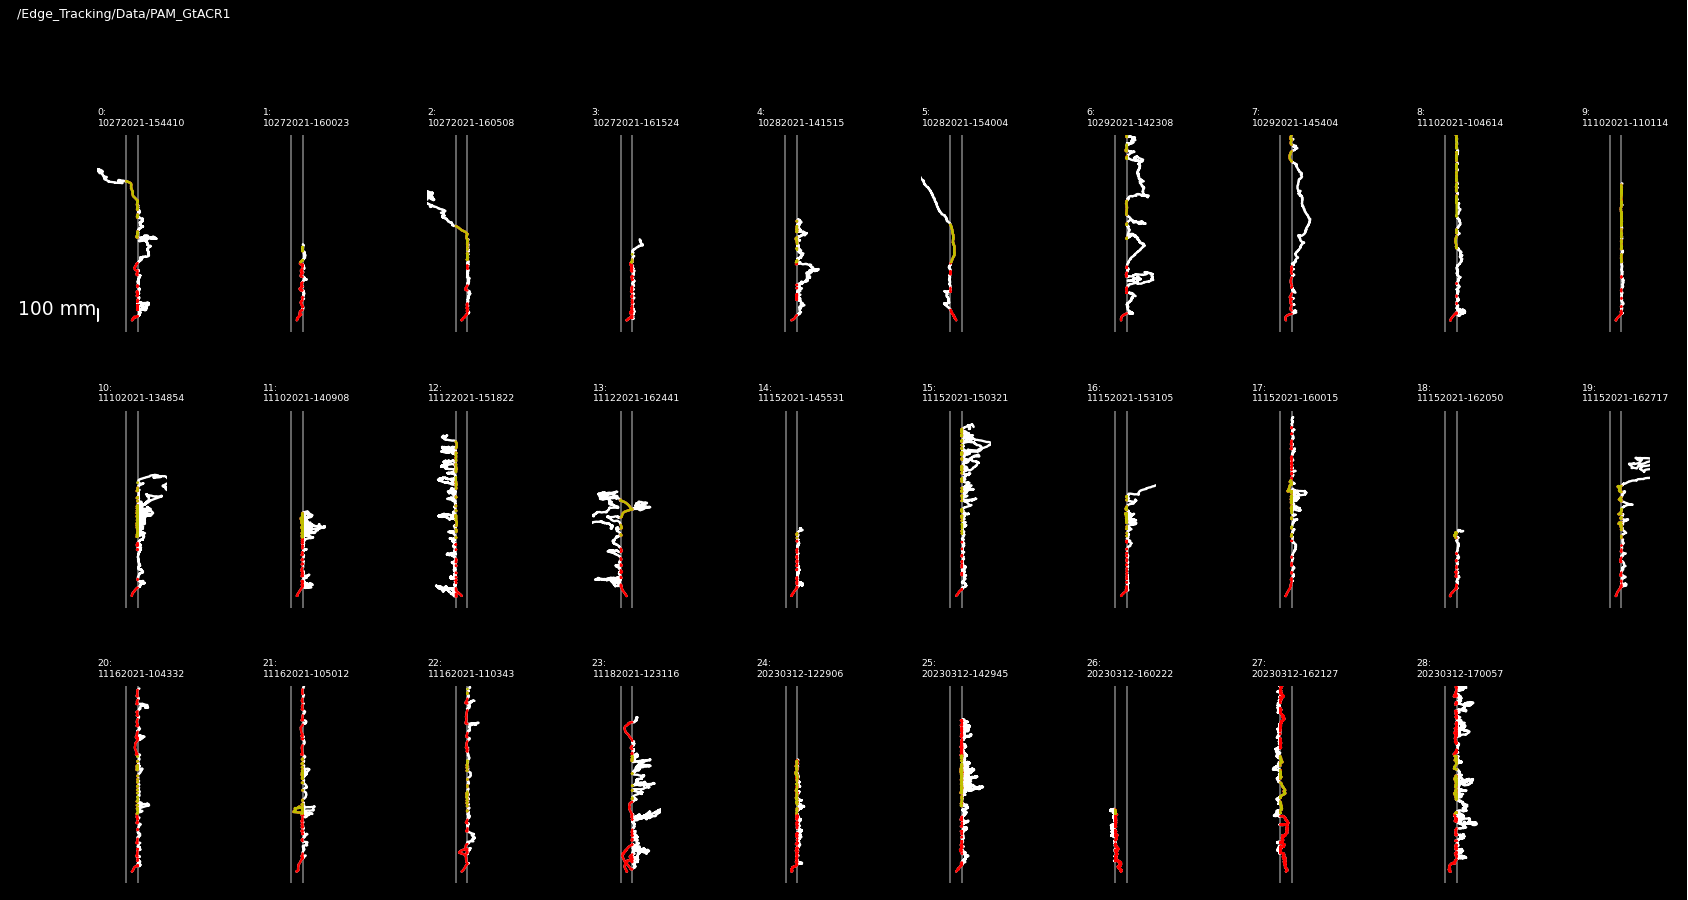

In [493]:
nr=3
nc = 10
bool_colors=['r', 'y']
bool_vars = ['instrip', 'led_on']
fig = putil.plot_array_of_trajectories(etdf, nr=nr, nc=nc, bool_colors=bool_colors, bool_vars=bool_vars, title='fly_id')
util.label_figure(fig, fig_id)
pl.savefig(os.path.join(curr_figdir, 'trajectories.png'))
pl.savefig(os.path.join(curr_figdir, 'trajectories.svg'))

## flip trajectories

In [504]:
d_list=[]
for fn, df_ in etdf.groupby('filename'):
    tmpdf = df_.copy().reset_index(drop=True)
    # odor boundaries
    odor_bounds = butil.find_strip_borders(tmpdf, 
                                        entry_ix=tmpdf[tmpdf['instrip']].iloc[0].name,
                                        strip_width=strip_width, strip_sep=1000)
    # get et info for PRE period
    tmpdf = df_.copy().reset_index(drop=True)
#     led_ix = tmpdf[tmpdf['led_on']].iloc[0].name
#     currdf = tmpdf.loc[0:led_ix].copy()
    last_bout_tmp = tmpdf[tmpdf['block']==0]['boutnum'].max()
    last_bout = last_bout_tmp if all(tmpdf[tmpdf['boutnum']==last_bout_tmp]['instrip']) else last_bout_tmp + 1
    currdf = tmpdf[tmpdf['boutnum'] <= last_bout].copy()
    # find all ET bouts (in case there is more than 1)
    et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(currdf,
                                    odor_bounds, strip_width=strip_width, strip_sep=strip_sep, 
                                   max_instrip_upwind_percent=max_instrip_upwind_percent, 
                                   max_crossovers=max_crossovers, 
                                    min_outside_bouts=min_outside_bouts)
    # flip trajectory so all riding along strip's right side -- flip WHOLE traj, not just pre LED period
    df_flipped, obounds_fp = butil.check_entryside_and_flip(tmpdf, odor_dict=et_bouts, strip_width=strip_width)
    d_list.append(df_flipped)
df_fp = pd.concat(d_list)

Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Not flipping borders
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Not flipping borders


In [505]:
df_fp['filename'].nunique()

29

#### check flipped

<IPython.core.display.Javascript object>


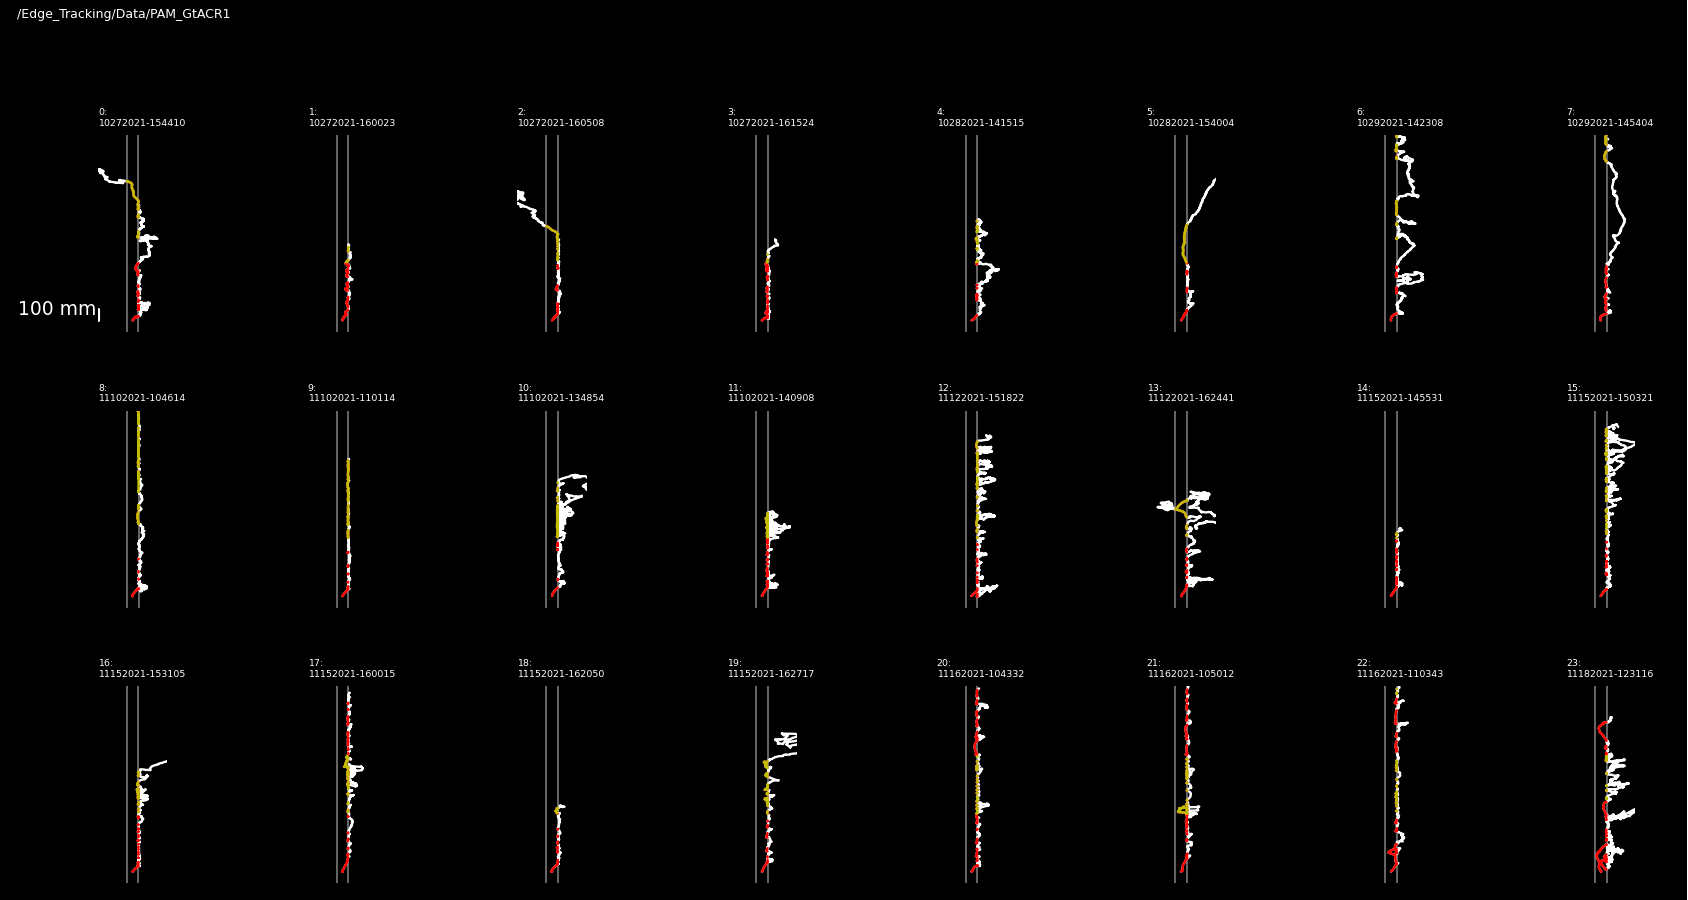

In [529]:
# plot flipped trajectories to check
bool_colors=['r', 'y']
bool_vars = ['instrip', 'led_on']
fig = putil.plot_array_of_trajectories(df_fp, nr=nr, nc=nc, bool_colors=bool_colors, bool_vars=bool_vars, title='fly_id')
util.label_figure(fig, fig_id)
pl.savefig(os.path.join(curr_figdir, 'trajectories_fp.png'))
pl.savefig(os.path.join(curr_figdir, 'trajectories_fp.svg'))

In [530]:
etdf = df_fp.copy()

In [531]:
etdf_multi = etdf[etdf['filename'].isin(multi_block)].copy()

#### only take first 2 blocks

In [532]:
min_nbouts_post=5
e_list = []
for fn, df_ in etdf.groupby('filename'):
    #if fn in multi_block:
        #last_bout = df_[(df_['instrip']) & (df_['led_on'])]['boutnum'].max() + 1 # last INSTRIP bout (since activating inside), then add subsequent outside bout
        #currdf = df_[df_['boutnum']<=last_bout]
    first_led_block = df_[df_['led_on']].iloc[0]['block']
    currdf = df_[df_['block'] <=first_led_block ]
#     else:
#         currdf = df_.copy()
    nbouts_post = df_[df_['block']==first_led_block]['boutnum'].nunique()
    if nbouts_post < min_nbouts_post:
        continue
    e_list.append(currdf)
etdf_2blocks = pd.concat(e_list, axis=0)

In [533]:
etdf_2blocks['filename'].nunique(), nr, nc

(24, 3, 8)

In [534]:
# # exclude trials if POST period is too short
# nbouts_post = boutdf_filt[boutdf_filt['epoch']=='ledon']\
#                     .groupby('filename')['boutnum'].count().reset_index()
# nbouts_pre = boutdf_filt[boutdf_filt['epoch']=='ledoff']\
#                     .groupby('filename')['boutnum'].count().reset_index()
# enough_post_bouts = nbouts_post[nbouts_post['boutnum']>=5]['filename'].values

# enough_post_bouts = nbouts_post[nbouts_post['boutnum']>=5]['filename'].values
# etdf_2blocks = etdf_2blocks[etdf_2blocks['filename'].isin(enough_post_bouts)].copy()

#### double-check 1st 2 blocks only

In [535]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

<IPython.core.display.Javascript object>


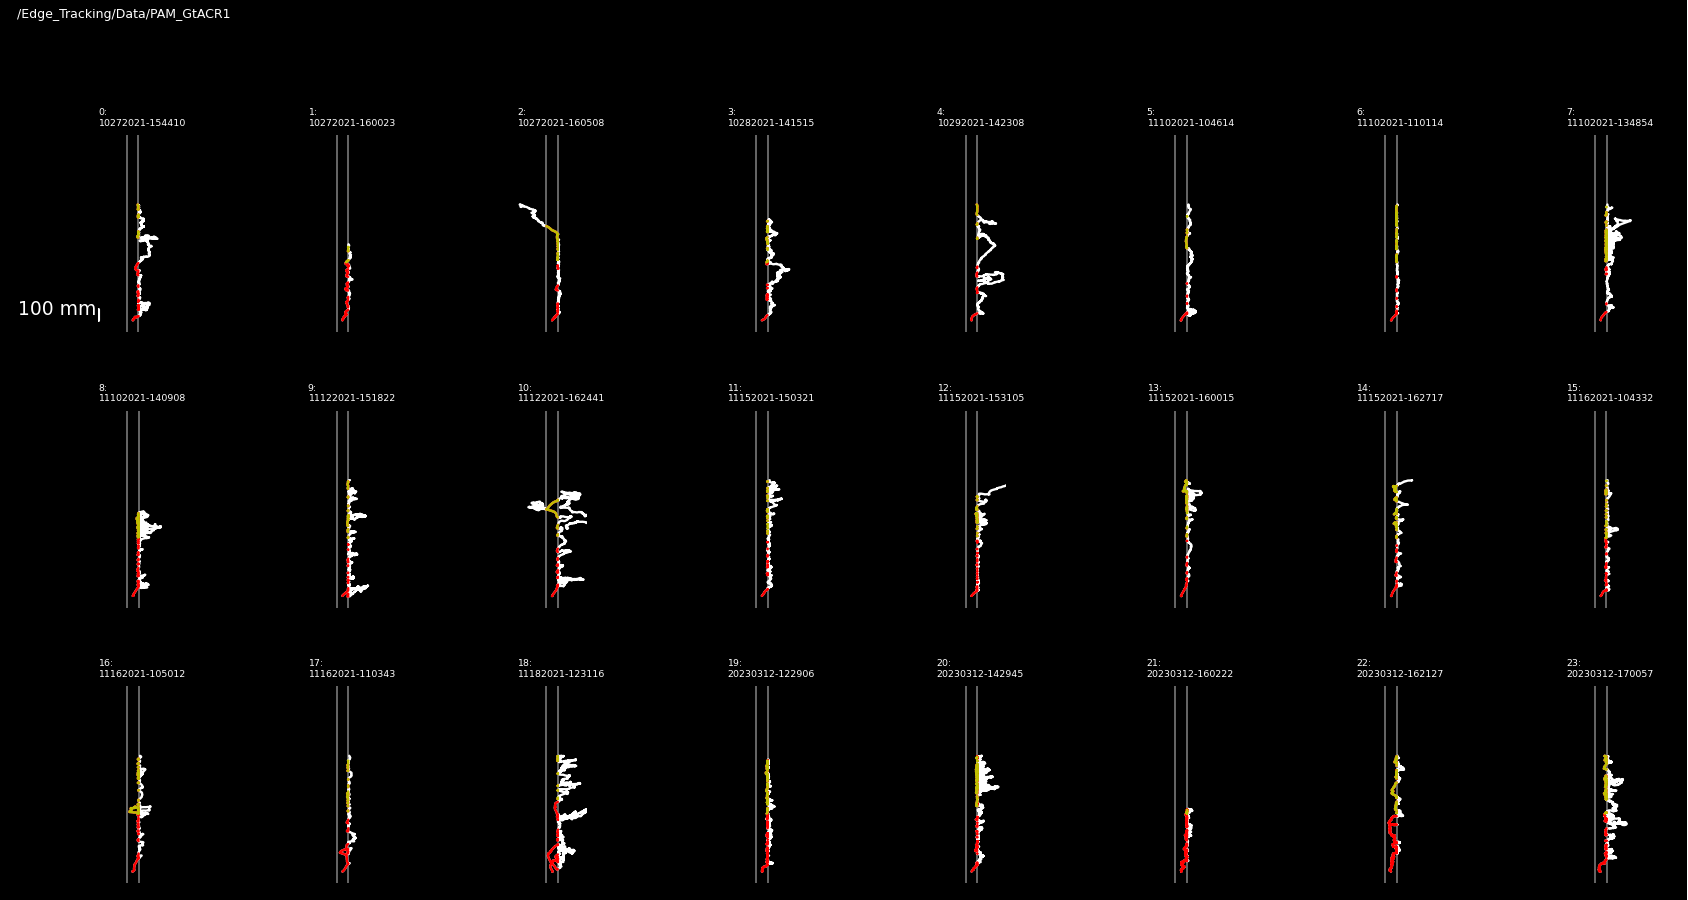

In [536]:
bool_colors=['r', 'y']
bool_vars = ['instrip', 'led_on']
fig = putil.plot_array_of_trajectories(etdf_2blocks, nr=nr, nc=nc, bool_colors=bool_colors, bool_vars=bool_vars, title='fly_id')
util.label_figure(fig, fig_id)
pl.savefig(os.path.join(curr_figdir, 'trajectories_2blocks.png'))
pl.savefig(os.path.join(curr_figdir, 'trajectories_2blocks.svg'))

#### double-check 3 block flies

In [537]:
len(multi_block)

8

In [538]:
etdf_multi['filename'].nunique()

8

In [539]:
etdf_multi['block'].max()

5

Total 8 flies with 3 blocks.


<IPython.core.display.Javascript object>


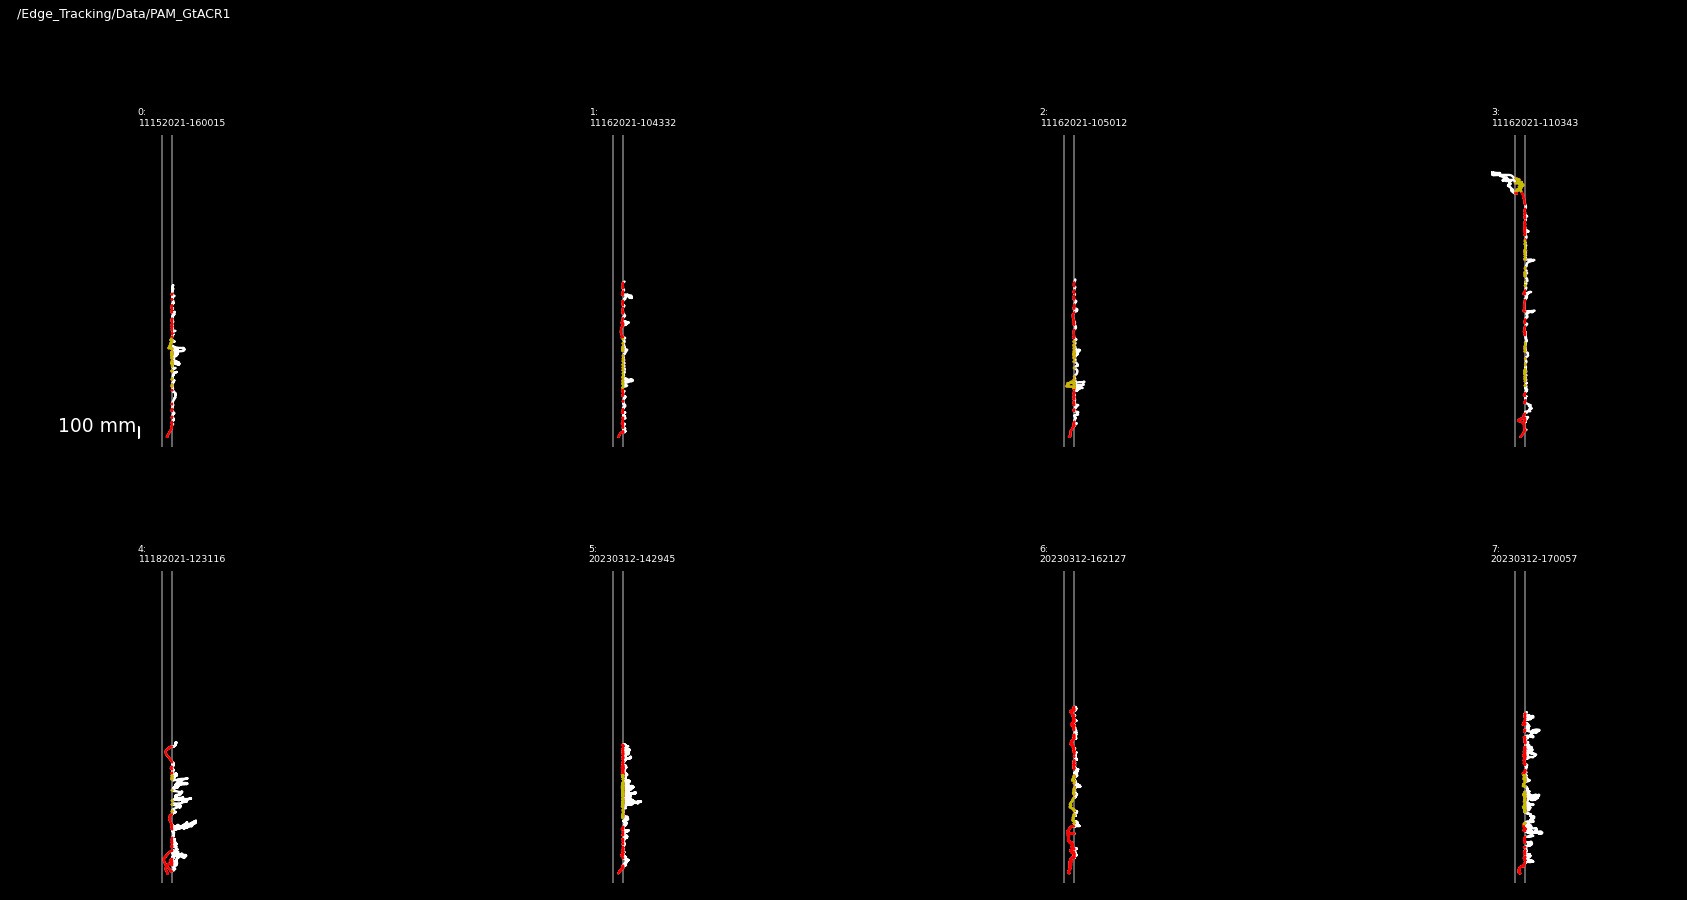

In [540]:
print("Total {} flies with 3 blocks.".format(len(multi_block)))
#etdf_multi = etdf[etdf['filename'].isin(multi_block)].copy()
fig = putil.plot_array_of_trajectories(etdf_multi, nr=2, nc=int(len(multi_block)/2), 
                                       bool_colors=bool_colors, bool_vars=bool_vars, title='fly_id', sharey=False)
util.label_figure(fig, fig_id)
pl.savefig(os.path.join(curr_figdir, 'trajectories_3blocks.png'))
pl.savefig(os.path.join(curr_figdir, 'trajectories_3blocks.svg'))

# Zero trajectories

In [541]:
df_z = [putil.zero_trajectory(df_) for fn, df_ in etdf_2blocks.groupby('filename')]
etdf_zero = pd.concat(df_z).reset_index(drop=True)

# includd dist_from_edge
etdf_zero['dist_from_edge'] = etdf_zero['ft_posx'] - 25
etdf_zero['dist_from_edge_abs'] = abs(etdf_zero['dist_from_edge'])
etdf_zero.loc[etdf_zero['instrip'], 'dist_from_edge_abs'] = (25 - etdf_zero.loc[etdf_zero['instrip'], 'ft_posx']) 
# abs( etdf_multi_zero['ft_posx'] ) - 25

# Average bouts

In [542]:
xvar='ft_posx'
yvar='ft_posy'

ledoff_color = 'w'
ledon_color='g'

epoch_palette = {'ledoff': 'w', 'ledon': 'g'}

## plot each fly's avg bout in 1 figure

In [543]:
curr_figdir = os.path.join(figdir, 'ets')

In [544]:
len(etdf_zero['filename'].unique())

24

<IPython.core.display.Javascript object>


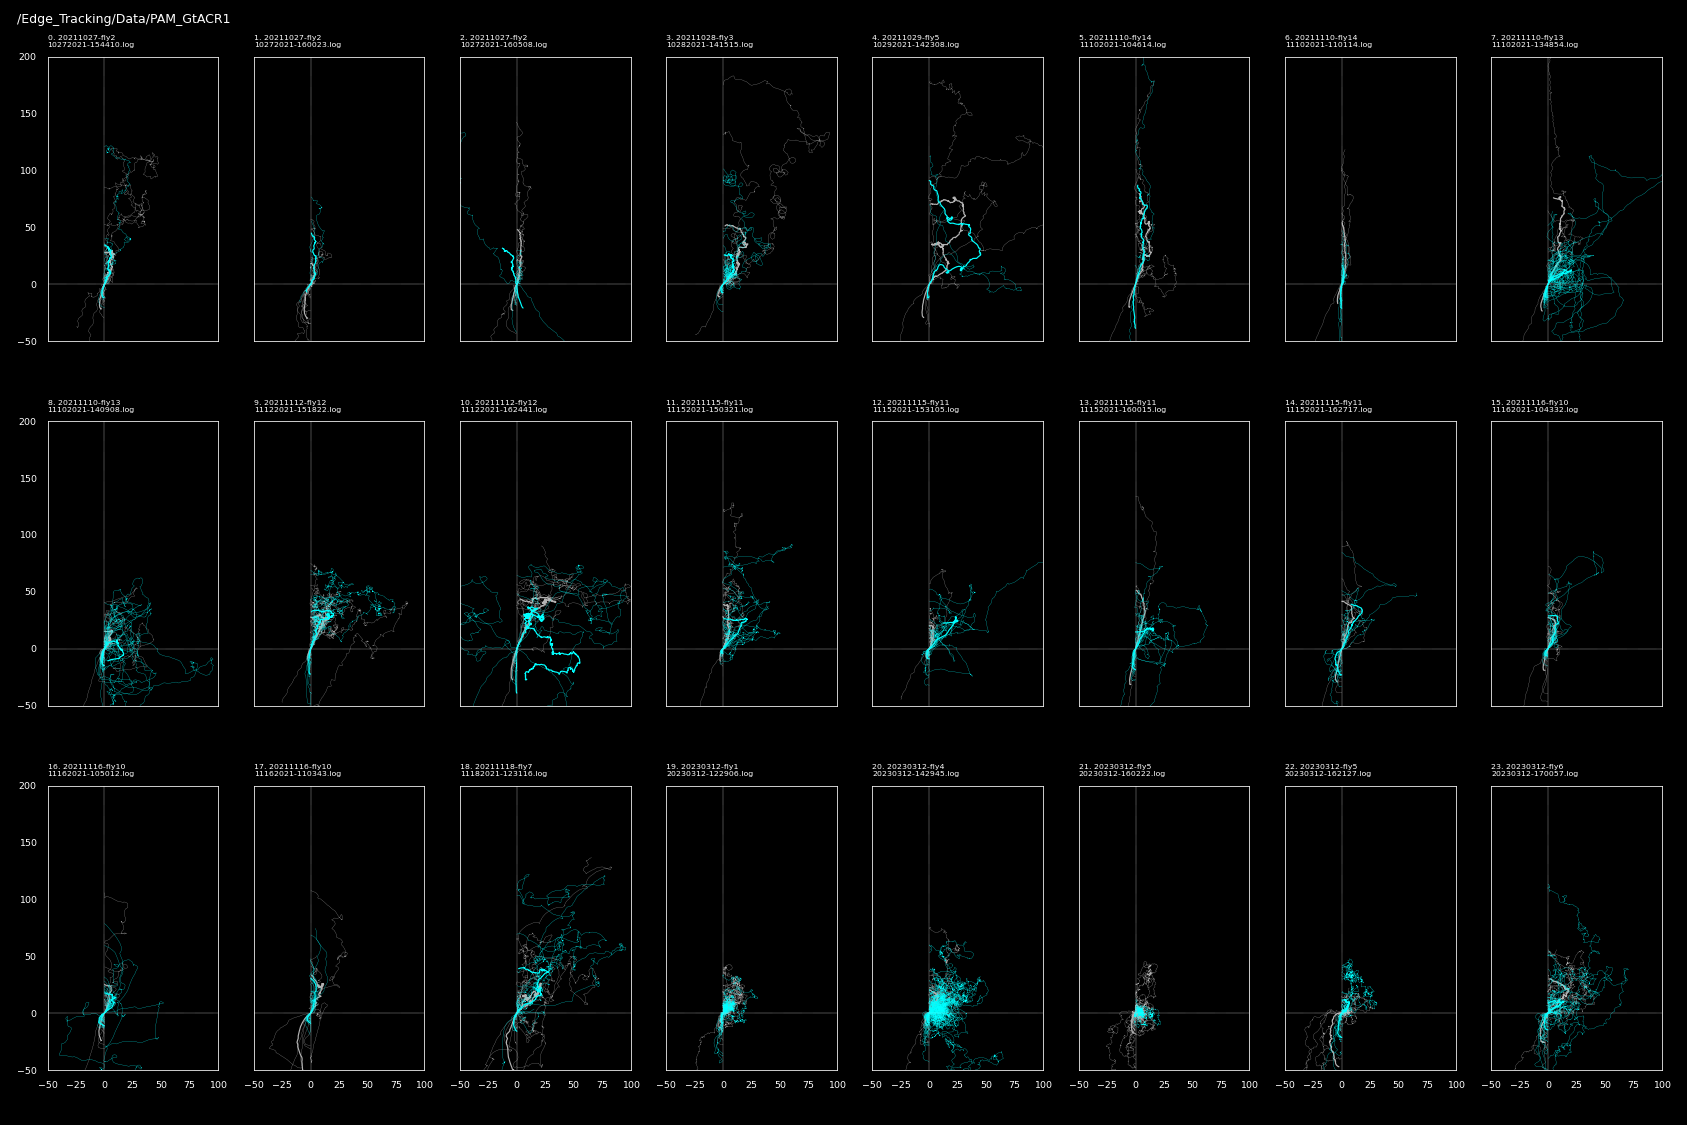

In [551]:
plot_all = True

xvar='ft_posx'
yvar='ft_posy'
epoch_palette = {'ledoff': [0.7]*3, 'ledon': 'cyan'}
ledoff_color = epoch_palette['ledoff']
ledon_color= epoch_palette['ledon']
# --------------------------------------------------------
max_nframes = etdf_zero.groupby(['filename', 'instrip', 'boutnum'])['ft_frame'].nunique().max()
if plot_all:
    lw=0.15
    avg_lw=0.76
    nr=3
    nc=8
    fig, axn = pl.subplots( nr, nc, sharex=True, sharey=True, figsize=(15, 10)) # figsize=(8,8))

    for fi, (fn, trialdf) in enumerate(etdf_zero.groupby('filename')):
        fly_id = trialdf['fly_id'].unique()[0]
        epochs = ['ledoff', 'ledon']
        ax=axn.flat[fi]
        for epoch, epoch_df in trialdf.groupby('epoch'):
#             if epoch=='ledoff':
                # skip 1st starting instrip, and include last OUTSTRIP only
            first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() # start at first in/out bout after 1st
            last_bout = epoch_df[~epoch_df['instrip']]['boutnum'].max() # end at last outbout
#             else:
#                 # first POST bout is instrip (by definition, led_on=True), 
#                 # so skip 1st starting instrip, and include last INSTRIP only
#                 first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() # start at first in bout (since mid trajectory)
#                 last_bout = epoch_df[epoch_df['instrip']]['boutnum'].max() - 1# # 
            drop_cols = epoch_df.columns[epoch_df.isna().any()].tolist()
            incl_cols = [c for c in epoch_df.columns if c not in drop_cols]
            df_ = epoch_df[(epoch_df['boutnum']>=first_bout) & (epoch_df['boutnum']<=last_bout)][incl_cols].copy()
            # interpolate and align
            interp_x_in, interp_y_in, avg_x_in, avg_y_in = traj.align_and_average_bout_center0(df_[df_['instrip']], end_at_zero=True)
            interp_x_out, interp_y_out, avg_x_out, avg_y_out = traj.align_and_average_bout_center0(df_[~df_['instrip']], end_at_zero=False)                                                                                 
            # plot each
            ax.plot(interp_x_in, interp_y_in, lw=lw, color=epoch_palette[epoch])
            ax.plot(interp_x_out, interp_y_out, lw=lw, color=epoch_palette[epoch])
            # plot avg
            ax.plot(avg_x_in, avg_y_in, lw=avg_lw, color=epoch_palette[epoch])
            ax.plot(avg_x_out, avg_y_out, lw=avg_lw, color=epoch_palette[epoch])
            # plot 0,0
            ax.axhline(y=0, linestyle=':', color='w', lw=0.25)
            ax.axvline(x=0, linestyle=':', color='w', lw=0.25)
            ax.set_title('{}. {}{}{}.log'.format(fi, fly_id, '\n', fn.split('_')[0]), loc='left', fontsize=5)
            #ax.set_aspect(1)
            ax.set_ylim((-50, 200))
            ax.set_xlim((-50, 100))
            ax.set_aspect(1)
    for i in np.arange(fi+1, nr*nc):
        axn.flat[i].axis('off')
    util.label_figure(fig, fig_id)
    pl.tight_layout()
    pl.savefig(os.path.join(curr_figdir, 'avgbouts.png'), dpi=300) #_{}.png'.format(fn)))
    pl.savefig(os.path.join(curr_figdir, 'avgbouts.svg')) #_{}.png'.format(fn)))

# average bout across flies

In [546]:
importlib.reload(traj)

<module 'trajectory' from '/home/julianarhee/Repositories/plume-tracking/trajectory.py'>

In [547]:
max_nframes

42639

In [552]:
d_list = []
#min_bouts_to_average=3
max_nframes = etdf_zero.groupby(['filename', 'instrip', 'boutnum'])['ft_frame'].nunique().max()
for fn, trialdf in etdf_zero.groupby('filename'):
    fly_id = trialdf['fly_id'].unique()[0]
    epochs = ['ledoff', 'ledon']
    for epoch, epoch_df in trialdf.groupby('epoch'):
        ai = epochs.index(epoch)
        first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() # start at first in/out bout after 1st
        last_bout = epoch_df[~epoch_df['instrip']]['boutnum'].max() 
#         if epoch=='ledoff':
#             # skip 1st starting instrip, and include last OUTSTRIP only
#             first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min()+2 # start at first in/out bout after 1st
#             last_bout = epoch_df[~epoch_df['instrip']]['boutnum'].max() # end at last outbout
#         else:
#             # first POST bout is instrip (by definition, led_on=True), 
#             # so skip 1st starting instrip, and include last INSTRIP only
#             first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() # start at first in bout (since mid trajectory)
#             last_bout = epoch_df[epoch_df['instrip']]['boutnum'].max() - 1# # 
        drop_cols = epoch_df.columns[epoch_df.isna().any()].tolist()
        incl_cols = [c for c in epoch_df.columns if c not in drop_cols]
        df_ = epoch_df[(epoch_df['boutnum']>=first_bout) & (epoch_df['boutnum']<=last_bout)][incl_cols].copy()
        # interpolate and align
        for is_instrip, tmpdf in df_.groupby('instrip'):
            interp_x_in, interp_y_in, avg_x_in, avg_y_in = traj.align_and_average_bout_center0(tmpdf, end_at_zero=is_instrip)
            avg_ = pd.DataFrame({
                'avg_x': avg_x_in, 
                'avg_y': avg_y_in,
                'filename': fn,
                'fly_id': fly_id,
                'epoch': epoch,
                'instrip': is_instrip
            })
            d_list.append(avg_)
avgdf = pd.concat(d_list)

In [553]:
n_traj = len(avgdf['filename'].unique())
n_flies = len(avgdf['fly_id'].unique())
print(n_traj, n_flies)
epoch_palette= {'ledon': 'cyan', 'ledoff': [0.7]*3}

24 13


<IPython.core.display.Javascript object>


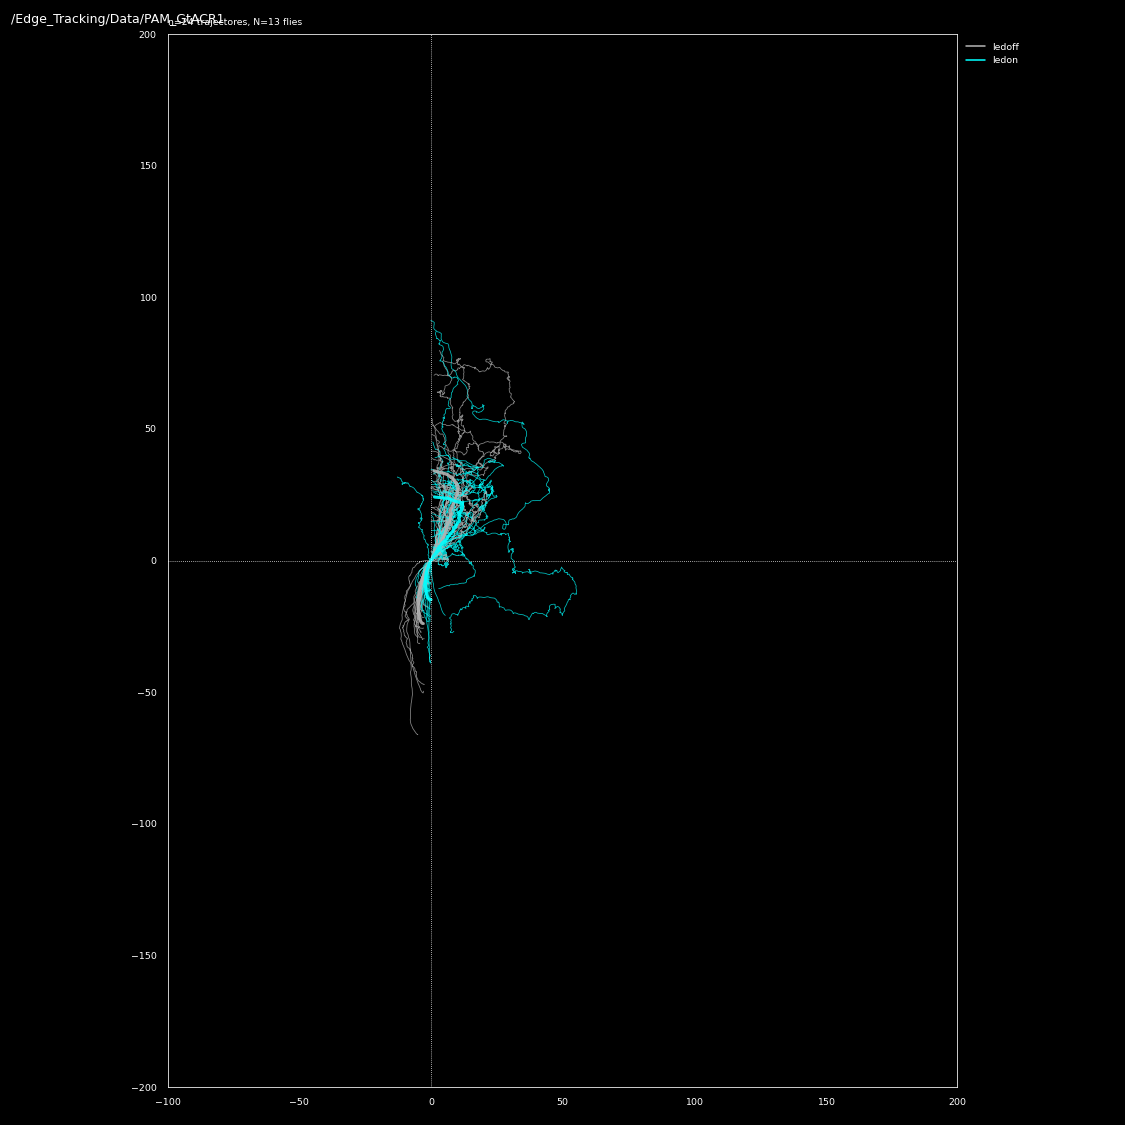

In [609]:
#avgdf = pd.concat(d_list)
lw=0.5
avg_lw=2
# excl = ['11122021-151822_PAMGtACR1_Fly1_001']
excl=[]
plotdf = avgdf[~avgdf['filename'].isin(excl)].copy()

plotdf['index'] = plotdf.index.tolist()
plotdf.groupby('index')['avg_x'].mean()

fig, ax = pl.subplots(figsize=(10,10))

epoch='ledoff'
for (fn, epoch, instrip), epochdf in plotdf.groupby(['filename', 'epoch', 'instrip']):
    ax.plot(epochdf['avg_x'], epochdf['avg_y'], color=epoch_palette[epoch], lw=lw, alpha=0.75)
    
plotdf['index'] = plotdf.index.tolist()

for (epoch, instrip), plotdf_ in plotdf.groupby(['epoch', 'instrip']):
    x_ = plotdf_.groupby('index')['avg_x'].mean()
    y_ = plotdf_.groupby('index')['avg_y'].mean()
    ax.plot(x_, y_, lw=avg_lw, color=epoch_palette[epoch], alpha=0.9)
ax.set_title("n={} trajectores, N={} flies".format(n_traj, n_flies), loc='left', fontsize=6)

ax.axhline(y=0, linestyle=':', color='w', lw=0.5)
ax.axvline(x=0, linestyle=':', color='w', lw=0.5)
ax.set_aspect(1)
ax.set_ylim([-200, 200])
ax.set_xlim([-100, 200])

labels = ['ledoff', 'ledon']
colors = [epoch_palette[i] for i in labels]
legh = putil.custom_legend(labels, colors, use_line=True, lw=1)
ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)

util.label_figure(fig, fig_id)
pl.tight_layout()
pl.savefig(os.path.join(curr_figdir, 'avgbout-avgfly.png'), dpi=300) #_{}.png'.format(fn)))
pl.savefig(os.path.join(curr_figdir, 'avgbout-avgfly.svg'), dpi=300) #_{}.png'.format(fn)))

# Average bout metrics

In [555]:
yvarnames = ['duration', 'speed','path_length', 
            'path_length_x', 'path_length_y',
            'crosswind_speed', 'crosswind_dist_range', 
            'upwind_speed', 'upwind_dist_range', 
            'max_dist_from_edge_abs', 'max_dist_from_edge', 'average_ft_heading']

#### filter out 1st instrip and last outstrip

In [557]:
# boutdf = pd.concat([df_.groupby(['boutnum', 'condition'], group_keys=True)\
#                  .apply(butil.get_bout_metrics).unstack().reset_index() \
#                  for (fi, fn), df_ in etdf.groupby(['fly_id', 'filename'])]).reset_index()
importlib.reload(butil)

group_vars = ['fly_id', 'filename', 'boutnum', 'condition']
boutdf = butil.get_bout_metrics(etdf_zero) #,numeric=numeric)

boutdf_filt = traj.filter_first_instrip_last_outstrip(boutdf)
# # --------------------------------------------------------
# mean_boutdf = boutdf_filt.groupby(['filename', 'fly_id', 'instrip', 'condition', 'bout_type', 'epoch']).mean().reset_index()
# # mean_boutdf['bout_type'] = ['instrip' if i==1 else 'outstrip' for i in mean_boutdf['instrip']]
# mean_boutdf['instrip'] = mean_boutdf['instrip'].astype(bool)
# mean_boutdf['led_on'] = mean_boutdf['led_on'].astype(bool)

(1170, 56)


In [611]:
estimator='median'
# -----------------------
if estimator=='max':
    metrics = boutdf_filt.groupby(['fly_id', 'filename', 'condition', 'block', 'epoch', 'instrip'], as_index=False).max()
elif estimator == 'mean':
    metrics = boutdf_filt.groupby(['fly_id', 'filename', 'condition',  'block', 'epoch', 'instrip'], as_index=False).mean()
else: #estimator should be median
    metrics = boutdf_filt.groupby(['fly_id', 'filename', 'condition', 'block', 'epoch', 'instrip'], as_index=False).median()
metrics['bout_type'] = ['instrip' if v==True else 'outstrip' for v in metrics['instrip']]
metrics['epoch_type'] = ['{}-{}'.format(a, b) for a, b in metrics[['bout_type', 'epoch']].values]
# Add max pos
# maxy = etdf_zero.groupby(['fly_id', 'filename', 'epoch', 'instrip', 'condition'], \
#                   as_index=False).apply(lambda x: x['ft_posy'].max() - x['ft_posy'].min()).rename(columns={None: 'ft_posy_max'})
# print(maxy.shape, boutdf.shape)
# metrics = pd.merge(metrics, maxy, on=['fly_id', 'filename', 'instrip', 'condition'] )

max_y_in_block = etdf_zero.groupby(['fly_id', 'filename', 'epoch', 'block', 'instrip'], \
                  as_index=False).apply(lambda x: x['ft_posy'].max() - x['ft_posy'].min()).rename(columns={None: 'ft_posy_max'})
for (fn, ep, bk, ins), df_ in max_y_in_block.groupby(['filename', 'epoch', 'block', 'instrip']):
    metrics.loc[(metrics['filename']==fn) 
                & (metrics['block']==bk)
                & (metrics['epoch']==ep)
                & (metrics['instrip']==ins), 'ft_posy_max'] = float(df_['ft_posy_max'])
# metrics.pop('boutnum')
#metrics.pop('ft_posy')
metrics['bout_type'] = ['instrip' if v==True else 'outstrip' for v in metrics['instrip'].values]
print(metrics.shape, metrics.dropna().shape)


/tmp/ipykernel_6076/4117197274.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metrics = boutdf_filt.groupby(['fly_id', 'filename', 'condition', 'block', 'epoch', 'instrip'], as_index=False).median()


(96, 49) (16, 49)


In [622]:
yvarnames.append('ft_posy_max')

In [612]:
# for (fn, bk), df_ in max_y_in_block.groupby(['filename', 'block']):
#     metrics.loc[(metrics['filename']==fn) & (metrics['block']==bk), 'ft_posy_max'] = float(df_['ft_posy_max'])

In [613]:
### maxy should be max minus min for EACH epoch:

In [614]:
# boutdf_filt = traj.filter_first_instrip_last_outstrip(boutdf)
# # boutdf_filt = boutdf.copy()
# # --------------------------------------------------------
# mean_boutdf = boutdf_filt.groupby(\
#                 ['fly_id', 'filename', 'instrip', 'condition', 'epoch'], \
#                 as_index=False).mean()#.reset_index()
# # mean_boutdf['bout_type'] = ['instrip' if i==1 else 'outstrip' for i in mean_boutdf['instrip']]
# mean_boutdf['instrip'] = mean_boutdf['instrip'].astype(bool)
# mean_boutdf['led_on'] = mean_boutdf['led_on'].astype(bool)
# print(mean_boutdf.shape)

In [615]:
# col_sel = ['ft_posy_max', 'fly_id', 'filename', 'instrip', 'condition', 'epoch']
# grouper = ['fly_id', 'filename', 'instrip', 'condition', 'epoch']
# mean_boutdf = pd.merge(mean_boutdf, maxy[col_sel], on=grouper )

# metrics.shape, mean_boutdf.shape

In [616]:
# epoch_counts = mean_boutdf.groupby('filename')['epoch'].count().reset_index()
# excluded_files = epoch_counts[epoch_counts['epoch']!=4]['filename'].values
# mean_boutdf = mean_boutdf[~mean_boutdf['filename'].isin(excluded_files)]
epoch_counts = metrics.groupby('filename')['epoch'].count().reset_index()
excluded_files = epoch_counts[epoch_counts['epoch']!=4]['filename'].values
excluded_files
metrics = metrics[~metrics['filename'].isin(excluded_files)]

# paired summary metrics

In [617]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

In [618]:
yvarnames = ['duration', 'speed','path_length', 
            'path_length_x', 'path_length_y',
            'crosswind_speed', 'crosswind_dist_range', 
            'upwind_speed', 'upwind_dist_range', 
            'max_dist_from_edge_abs', 'max_dist_from_edge', 'average_ft_heading', 'ft_posy_max']
len(yvarnames)
# curr_plotvars = ['speed', 'crosswind_dist_range', 'max_dist_from_edge_abs', 'upwind_speed', 'crosswind_speed', 'ft_posy_max']
# len(curr_plotvars)

13

In [619]:
pl.rcParams['svg.fonttype'] = 'none'

/tmp/ipykernel_6076/3716680698.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_oneper = metrics.groupby(['fly_id', 'filename', 'epoch', 'instrip', 'bout_type', 'epoch_type'], as_index=False).median()


<IPython.core.display.Javascript object>


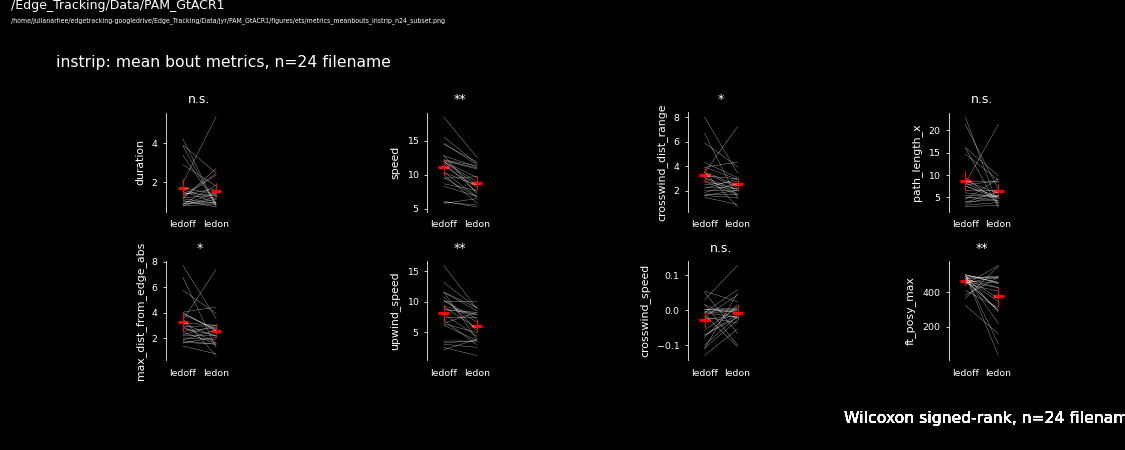

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/Repositories/plume-tracking/plotting.py:197: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oneval_per= df_.groupby([pair_by, xvarname], as_index=False).mean()
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may c

metrics_meanbouts_instrip_n24_subset


<IPython.core.display.Javascript object>


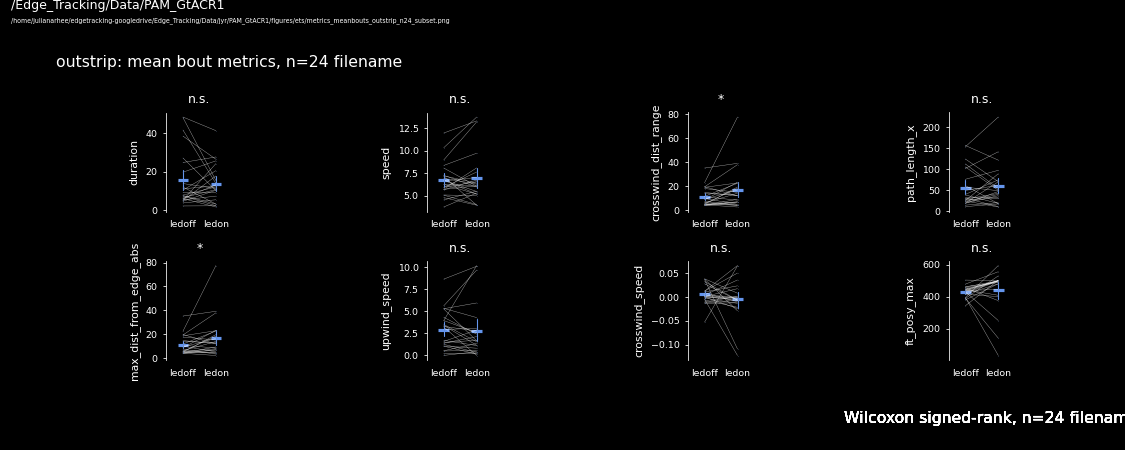

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.39215686274509803, 0.5843137254901961, 0.9294117647058824), (0.39215686274509803, 0.5843137254901961, 0.9294117647058824)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/Repositories/plume-tracking/plotting.py:197: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oneval_per= df_.groupby([pair_by, xvarname], as_index=False).mean()
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.39215686274509803, 0.5843137254901961, 0.92941176470588

metrics_meanbouts_outstrip_n24_subset


In [643]:
#curr_plotvars = yvarnames
curr_plotvars = ['duration', 'speed', 'crosswind_dist_range', 'path_length_x',
                 'max_dist_from_edge_abs', 'upwind_speed', 'crosswind_speed', 'ft_posy_max']
nr = 2
nc = 4

mean_oneper = metrics.groupby(['fly_id', 'filename', 'epoch', 'instrip', 'bout_type', 'epoch_type'], as_index=False).median()

conds = ['instrip', 'outstrip']
dfs = [mean_oneper[mean_oneper['instrip']], mean_oneper[~mean_oneper['instrip']]]
#fly_ids = mean_oneper['fly_id'].unique()
pair_by = 'filename'
filenames = mean_oneper[pair_by].unique()

for currcond, df_ in zip(conds, dfs):
    fig = putil.plot_paired_inout_metrics(df_, pair_by=pair_by, 
                xvarname='epoch', yvarnames=curr_plotvars, nr=nr, nc=nc,
                xticklabels=['ledoff', 'ledon'], order=['ledoff', 'ledon'], 
                color=instrip_palette2[currcond], aspect=1.5,
                line_markersize=0.3, lw=0.25, alpha=0.7, plot_mean=True, errwidth=0.7)
    fig.text(0.05, 0.85, '{}: mean bout metrics, n={} {}'.format(currcond, len(filenames),  pair_by), fontsize=10)
    pl.subplots_adjust(top=0.75)
    util.label_figure(fig, fig_id)
    figname = 'metrics_meanbouts_{}_n{}_subset'.format(currcond, len(filenames))
    fig.text(0.01, 0.95, os.path.join(curr_figdir, '{}.png'.format(figname)), fontsize=4)

    pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))
    pl.savefig(os.path.join(curr_figdir, '{}.svg'.format(figname)))
    print(figname)

In [600]:
for (fn, epoch), df_ in metrics.groupby(['filename', 'epoch']):
    df_

In [601]:
df_

,fly_id,filename,condition,block,epoch,instrip,average_ft_heading,boutnum,crosswind_dist,crosswind_dist_firstlast,...,sig_status,speed,time,upwind_dist,upwind_dist_firstlast,upwind_dist_range,upwind_speed,bout_type,epoch_type,ft_posy_max
94,20230312-fly6,20230312-170057_PAM_activation_fly6-PAM-GtACR1...,lights,1,ledon,False,0.262267,42.0,0.073167,-0.014308,...,1.0,6.714795,1.678656e+09,0.048158,4.693641,14.988701,0.805709,instrip,outstrip-ledon,598.902363
95,20230312-fly6,20230312-170057_PAM_activation_fly6-PAM-GtACR1...,lights,1,ledon,True,-0.269497,43.0,0.071365,0.002918,...,1.0,7.692257,1.678656e+09,0.007055,6.351484,6.494810,3.652369,instrip,instrip-ledon,598.902363


## plot all 4 conds in one

In [623]:
yvarnames = ['duration', 'speed','path_length', 
            'path_length_x', 'path_length_y',
            'crosswind_speed', 'crosswind_dist_range', 
            'upwind_speed', 'upwind_dist_range', 
            'max_dist_from_edge_abs', 'max_dist_from_edge', 'average_ft_heading', 'ft_posy_max']
print(len(yvarnames))

13


In [644]:
# metrics_oneper = metrics.groupby(['fly_id', 'filename', 'epoch', 'instrip', 'bout_type', 'epoch_type'], as_index=False).mean()
# Merge for easier plotting
meltdf_metrics = pd.melt(mean_oneper, id_vars=['fly_id', 'bout_type', 'epoch', 'epoch_type'],
               value_vars=yvarnames, value_name='value')
meltdf_metrics['value'] = meltdf_metrics['value'].astype(float)

In [645]:
#curr_plotvars = yvarnames
curr_plotvars = ['duration', 'speed', 'crosswind_dist_range', 'path_length_x',
                 'max_dist_from_edge_abs', 'upwind_speed', 'crosswind_speed', 'ft_posy_max']
print(len(curr_plotvars))
plotdf = meltdf_metrics[meltdf_metrics['variable'].isin(curr_plotvars)].copy()

8


In [646]:
plotdf[plotdf['variable']=='ft_posy_max']

,fly_id,bout_type,epoch,epoch_type,variable,value
1152,20211027-fly2,outstrip,ledoff,outstrip-ledoff,ft_posy_max,463.008566
1153,20211027-fly2,instrip,ledoff,instrip-ledoff,ft_posy_max,495.678049
1154,20211027-fly2,outstrip,ledon,outstrip-ledon,ft_posy_max,491.533019
1155,20211027-fly2,instrip,ledon,instrip-ledon,ft_posy_max,285.762344
1156,20211027-fly2,outstrip,ledoff,outstrip-ledoff,ft_posy_max,391.788606
...,...,...,...,...,...,...
1243,20230312-fly5,instrip,ledon,instrip-ledon,ft_posy_max,491.392351
1244,20230312-fly6,outstrip,ledoff,outstrip-ledoff,ft_posy_max,394.859297
1245,20230312-fly6,instrip,ledoff,instrip-ledoff,ft_posy_max,443.998075
1246,20230312-fly6,outstrip,ledon,outstrip-ledon,ft_posy_max,594.953799


<IPython.core.display.Javascript object>


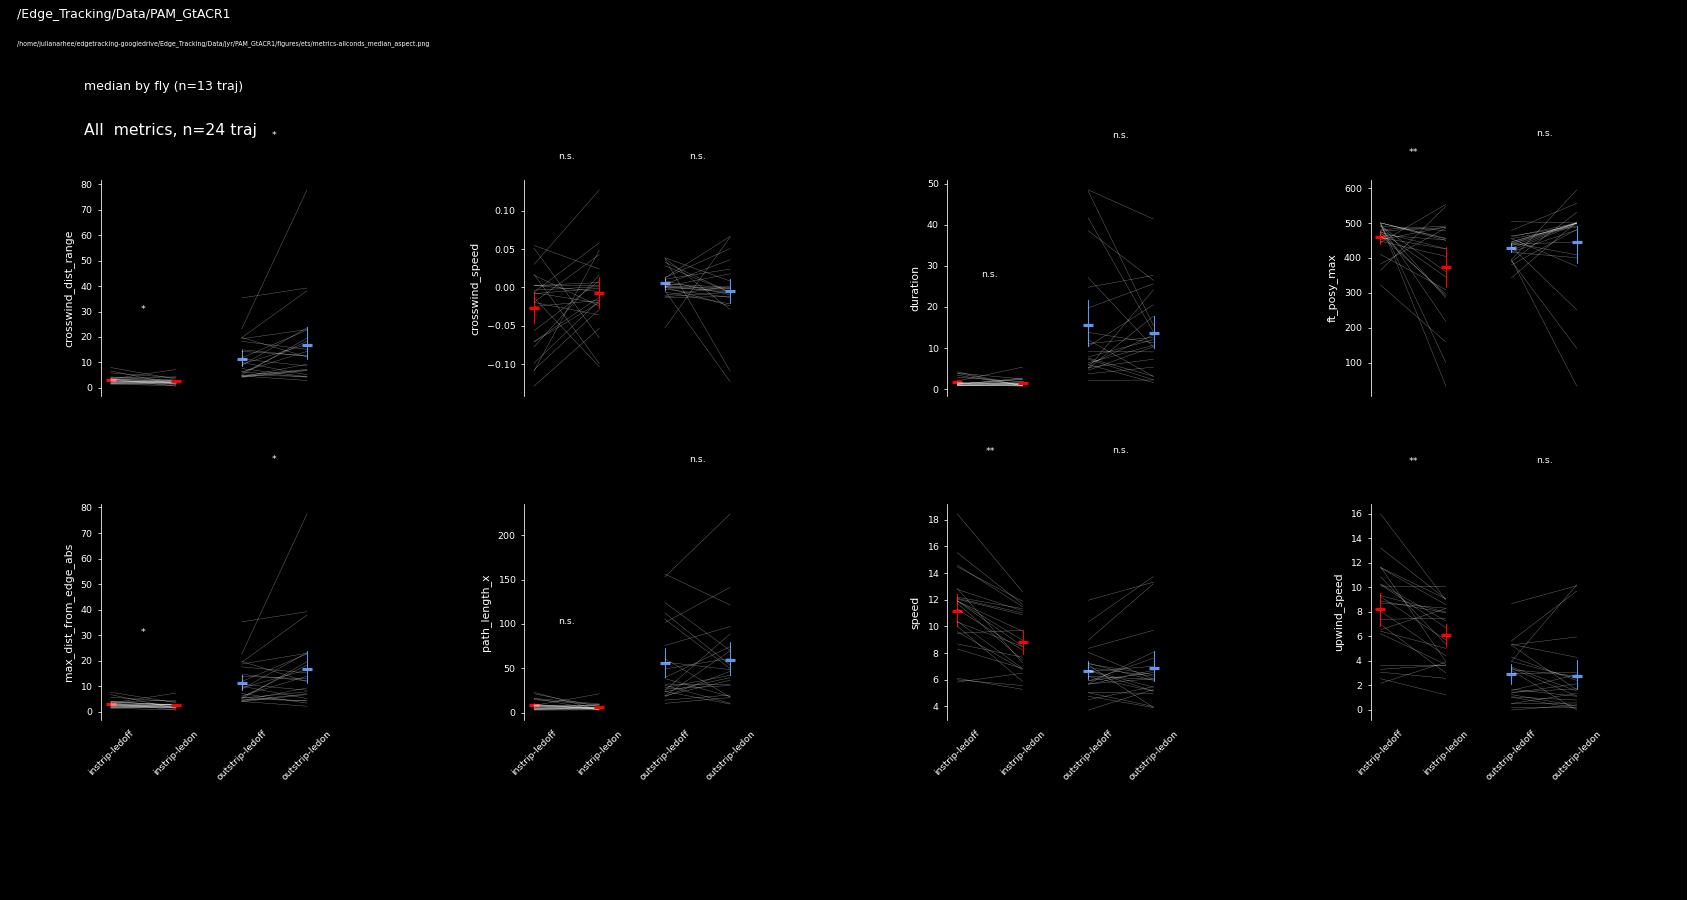

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.39215686274509803, 0.5843137254901961, 0.9294117647058824)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.0, 0.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.39215686274509803, 0.5843137254901961, 0.9294117647058824)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of t

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/ets/metrics-allconds_median_aspect.svg


In [672]:
# plot all paird metrics
crossfly_estimator='mean'

xorder = ['instrip-ledoff', 'instrip-ledon', 'outstrip-ledoff', 'outstrip-ledon']
epochtypes_palette = dict((k, instrip_palette2['instrip']) if 'instrip' in k else (k, instrip_palette2['outstrip']) for k in xorder)
n_fns = plotdf['fly_id'].nunique()

nr=2
nc=4
lw=0.25
alpha=0.5
fig, axn = pl.subplots(nr, nc, figsize=(15, 8))
# plot bout metrics
ci = 0; ri = 0;
for cond, cond_df in plotdf.groupby('variable'):
    if ci >= nc:
        ci = 0; ri = 1;
    ax=axn[ri, ci]
    sns.pointplot(data=cond_df, x='epoch_type', y='value', hue='epoch_type', order=xorder, ax=ax, 
                  markers='_',  scale=1, errwidth=0.7, join=False, palette=epochtypes_palette,
                  estimator=crossfly_estimator) #, jitter=False)
#     sns.stripplot(data=cond_df, x='epoch_type', y ='value', order=xorder, c='w',
#                   #hue='epoch_type', hue_order=xorder, palette=epochtypes_palette,
#                   ax=ax, s=0.3, alpha=0.7, jitter=True, legend=0)

    ci+=1
    ax.set_ylabel(cond)
    # stats
    for bi, bout in enumerate(['instrip', 'outstrip']):
        a = cond_df[cond_df['epoch_type']=='{}-ledoff'.format(bout)]['value'].values
        b = cond_df[cond_df['epoch_type']=='{}-ledon'.format(bout)]['value'].values
        xs = np.array([ [0]*len(a), [1]*len(a) ]) + (bi*2)
        ys = np.array([a, b])
        ax.plot(xs, ys, c='w', alpha=alpha, lw=lw)
        # stats: wilcoxon signed-rank test (nonparametric paired t)
        pdf = pd.DataFrame({'a': a, 'b': b})
        T, pv = spstats.wilcoxon(pdf["a"], pdf["b"], nan_policy='omit')
        if pv>=0.05:
            annot = 'n.s.'
        else:
            annot = '**' if pv<0.01 else '*'
#         ks = st.ks_2samp(a, b)
#         stat_string = 'ks: {:.2f}, p: {:.2f}'.format(ks['ks_stat'], ks['p_value'])
#         if ks['p_value']<0.05:
#             annot = '**' if ks['p_value']<0.01 else '*'
#         else:
#             annot='n.s.'
        ax.text(bi*2 + 0.5, ax.get_ylim()[-1]*1.2, annot, fontsize=6, ha='center')
    # axes
    putil.set_outward_spines(ax)
    putil.remove_spines(ax, axes=['right', 'top', 'bottom'])
    if ri==0:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
        ax.set_xlabel('')
    ax.set_box_aspect(1)
    ax.legend_.remove()
    

fig.text(0.05, 0.85, 'All  metrics, n={} traj'.format(len(filenames)), fontsize=10)
pl.subplots_adjust(top=0.8, hspace=0.5)
util.label_figure(fig, fig_id)

figname = 'metrics-allconds_{}_aspect'.format( estimator)
fig.text(0.01, 0.95, os.path.join(curr_figdir, '{}.png'.format(figname)), fontsize=4)
fig.text(0.05, 0.9, '{} by fly (n={} traj)'.format(estimator, n_fns), fontsize=8)

pl.subplots_adjust(wspace=0.7, hspace=0.5, bottom=0.2, top=0.8, left=0.05, right=0.95)
pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))
pl.savefig(os.path.join(curr_figdir, '{}.svg'.format(figname)))
print(os.path.join(curr_figdir, '{}.svg'.format(figname)))

#### plot paired metrics for each:
Show trajectory, then a bunch of subplots with each metric, all 4 conditions

In [ ]:
plot_each = False
# -------------------------------------------------------------------------------
xorder = ['instrip-ledoff', 'instrip-ledon', 'outstrip-ledoff', 'outstrip-ledon']
epoch_palette = dict((k, instrip_palette2['instrip']) if 'instrip' in k else (k, instrip_palette2['outstrip']) for k in xorder)
plotvars = yvarnames #yvar='speed'
if plot_each:
    curr_figdir = os.path.join(figdir, 'ets', 'by-individual')
    if not os.path.exists(curr_figdir):
        os.makedirs(curr_figdir)
    for fn, melt_ in meltdf.groupby('filename'):
        fly_id = melt_['fly_id'].unique()[0]
        traj_ = etdf_2blocks[etdf_2blocks['filename']==fn].copy()
        traj_ = putil.zero_trajectory(traj_)

        # fig, axn = pl.subplots(1, len(plotvars)+1, sharex=False, sharey=False, figsize=(8,3.5))
        fig = pl.figure( figsize=(8.5, 4.5))
        nr=2
        nc=6
        gs = mpl.gridspec.GridSpec(nr, nc, figure=fig)

        ax = fig.add_subplot(gs[0:, 0])
        putil.plot_zeroed_trajectory(traj_, ax=ax, bool_colors=bool_colors, bool_vars=bool_vars, traj_lw=1, odor_lw=0.5, main_col='cornflowerblue')

        ci = 0
        ri = 0
        for cond, cond_df in melt_.groupby('variable'):
            ci += 1
            if ci >= nc:
                ci = 1
                ri = 1

            ax=fig.add_subplot(gs[ri, ci])
            sns.pointplot(data=cond_df, x='epoch_type', y='value', order=xorder, ax=ax, 
                          markers='_', color='w', scale=1, errwidth=0.5, join=False) #, jitter=False)
            sns.stripplot(data=cond_df, x='epoch_type', y ='value', order=xorder, 
                          hue='epoch_type', hue_order=xorder, palette=epoch_palette,
                          ax=ax, c='w', s=3, alpha=0.5, jitter=True, legend=0)
            ax.set_ylabel(cond)
            # stats
            for bi, bout in enumerate(['instrip', 'outstrip']):
                a = cond_df[cond_df['epoch_type']=='{}-ledoff'.format(bout)]['value'].values
                b = cond_df[cond_df['epoch_type']=='{}-ledon'.format(bout)]['value'].values
                ks = st.ks_2samp(a, b)
                stat_string = 'ks: {:.2f}, p: {:.2f}'.format(ks['ks_stat'], ks['p_value'])
                if ks['p_value']<0.05:
                    annot = '**' if ks['p_value']<0.01 else '*'
                else:
                    annot='n.s.'
                ax.text(bi*2 + 0.5, ax.get_ylim()[-1]*1.2, annot, fontsize=6, ha='center')
            # axes
            putil.set_outward_spines(ax)
            putil.remove_spines(ax, axes=['right', 'top', 'bottom'])
            if ri==0:
                ax.set_xlabel('')
                ax.set_xticklabels([])
            else:
                ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
                ax.set_xlabel('')

        util.label_figure(fig, fig_id)
        if fn in enough_post_bouts:
            fig.text(0.05, 0.9, '{}: *{}.log'.format(fly_id, fn), fontsize=6)
        else:
            fig.text(0.05, 0.9, '{}: {}.log'.format(fly_id, fn), fontsize=6)
        pl.subplots_adjust(wspace=0.7, hspace=0.5, bottom=0.2, top=0.8, left=0.05, right=0.95)

        pl.savefig(os.path.join(curr_figdir, 'pre-post-silencing_{}'.format(fn)))


In [ ]:
curr_figdir

#### count bouts per x

In [241]:
group_vars = ['fly_id', 'filename', 'epoch', 'bout_type', 'epoch_type']
nbouts = boutdf_filt.groupby(group_vars)['boutnum'].count().reset_index()
durs = boutdf_filt.groupby(group_vars)['duration'].sum().reset_index()
lengths = boutdf_filt.groupby(group_vars)['path_length'].sum().reset_index()

durlen = pd.merge(nbouts, durs, on=group_vars).merge(lengths, on=group_vars)
durlen['bouts_per_sec'] = durlen['boutnum']/durlen['duration']
durlen['bouts_per_mm'] = durlen['boutnum']/durlen['path_length']

<IPython.core.display.Javascript object>


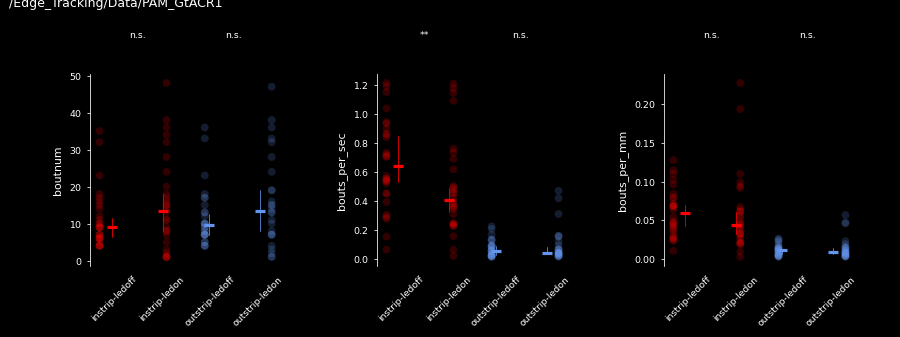

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.0, 0.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.39215686274509803, 0.5843137254901961, 0.9294117647058824)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.0, 0.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the

In [243]:
plot_vars = ['boutnum', 'bouts_per_sec', 'bouts_per_mm']
xorder = ['instrip-ledoff', 'instrip-ledon', 'outstrip-ledoff', 'outstrip-ledon']
epoch_palette = dict((k, instrip_palette2['instrip']) if 'instrip' in k else (k, instrip_palette2['outstrip']) for k in xorder)

fig, axn = pl.subplots(1, len(plot_vars), sharex=True, figsize=(8,3))

for ax, pvar in zip(axn.flat, plot_vars):
    sns.stripplot(data=durlen, x='epoch_type', y=pvar, ax=ax, hue='epoch_type', palette=epoch_palette, 
                  order=xorder, dodge=True, jitter=False , alpha=0.2, legend=0)
    sns.pointplot(data=durlen, x='epoch_type', y=pvar, ax=ax, hue='epoch_type', palette=epoch_palette, estimator='median',
                  order=xorder, dodge=True, markers='_', color='w', scale=1, errwidth=0.5, join=False)
    ax.legend_.remove()
    ax.set_box_aspect(1)
    ax.set_xlabel('')
    # stats
    for bi, bout in enumerate(['instrip', 'outstrip']):
        a = durlen[durlen['epoch_type']=='{}-ledoff'.format(bout)][pvar].values
        b = durlen[durlen['epoch_type']=='{}-ledon'.format(bout)][pvar].values
        ks = st.ks_2samp(a, b)
        stat_string = 'ks: {:.2f}, p: {:.2f}'.format(ks['ks_stat'], ks['p_value'])
        if ks['p_value']<0.05:
            annot = '**' if ks['p_value']<0.01 else '*'
        else:
            annot='n.s.'
        ax.text(bi*2 + 0.5, ax.get_ylim()[-1]*1.2, annot, fontsize=6, ha='center')
    # axes
    putil.set_outward_spines(ax)
    putil.remove_spines(ax, axes=['right', 'top', 'bottom'])

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('')
            
pl.subplots_adjust(left=0.1, right=0.95, wspace=0.50)
util.label_figure(fig, fig_id)

curr_figdir = os.path.join(figdir, 'ets')
pl.savefig(os.path.join(curr_figdir, 'bouts_per_sec.png'))


In [ ]:
plot_vars = ['speed', 'crosswind_dist_range', 'max_dist_from_edge_abs', 'upwind_speed', 'crosswind_speed']

In [2207]:
importlib.reload(traj)

<module 'trajectory' from '/home/julianarhee/Repositories/plume-tracking/trajectory.py'>

# sorted hists

In [155]:
pts = 1500
import scipy as sp
importlib.reload(traj)
fn

'20230312-170057_PAM_activation_fly6-PAM-GtACR1-2do-fastedF_000'

In [156]:
boutdf_long = boutdf_filt[boutdf_filt['filename'].isin(enough_post_bouts)].copy()
boutdf_long['bout_type'] = ['instrip' if v==True else 'outstrip' for v in boutdf_long['instrip']]

In [157]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

In [158]:
boutdf_long.columns

Index(['average_ft_heading', 'bout_type', 'boutnum', 'condition',
       'crosswind_dist', 'crosswind_dist_firstlast', 'crosswind_dist_range',
       'crosswind_speed', 'cum_time', 'date', 'dist_from_edge',
       'dist_from_edge_abs', 'duration', 'epoch', 'euclid_dist', 'experiment',
       'filename', 'flipped', 'fly_id', 'fly_name', 'fpath', 'ft_error',
       'ft_frame', 'ft_heading', 'ft_heading_og', 'ft_pitch', 'ft_posx',
       'ft_posx_abs', 'ft_posy', 'ft_roll', 'ft_yaw', 'instrip', 'led_on',
       'max_dist_from_edge', 'max_dist_from_edge_abs', 'min_dist_from_edge',
       'min_dist_from_edge_abs', 'n_frames', 'odor_on', 'path_length',
       'path_length_x', 'path_length_y', 'rel_time', 'sig_status', 'speed',
       'strip_type', 'time', 'timestamp', 'timestamp -- motor_step_command',
       'trial', 'trial_id', 'upwind_dist', 'upwind_dist_firstlast',
       'upwind_dist_range', 'upwind_speed', 'epoch_type'],
      dtype='object')

In [159]:
instrip_palette2 = {True: 'r', False: 'cornflowerblue'}
curr_figdir = os.path.join(figdir, 'ets')

In [165]:
epoch_palette = {'ledon': 'cyan', 'ledoff': 'gray'}

In [171]:
vars_to_flip = ['duration', 'speed_abs', 'path_length', 
                        'path_length_x', 'path_length_y', 'crosswind_dist_range', 
                        'upwind_speed_abs', 'upwind_dist_range', 'crosswind_speed_abs',
                'max_dist_from_edge_abs', 'ft_posy']


/tmp/ipykernel_1327527/281786940.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  med_vals = plotdf.groupby(['instrip', 'epoch']).mean().reset_index()


<IPython.core.display.Javascript object>


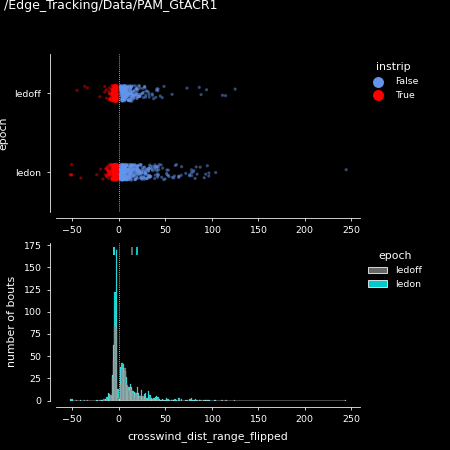

In [183]:
varn = 'crosswind_dist_range'
offset=1
plotdf = boutdf_long.copy()
estimator='mean'
plotvar = '{}_abs_flipped'.format(varn) if 'speed' in varn else '{}_flipped'.format(varn)
nbins = 20 if varn=='path length' else 200 #if 

plotdf = putil.flip_data_for_abutting_hists(plotdf, offset=offset, vars_to_flip=vars_to_flip)

if estimator=='median':
    med_vals = plotdf.groupby(['instrip', 'epoch']).median().reset_index()
else:
    med_vals = plotdf.groupby(['instrip', 'epoch']).mean().reset_index()

fig = pl.figure(figsize=(4,4)) # sharex=True)
gs = mpl.gridspec.GridSpec(2,1, figure=fig )
# create sub plots as grid
ax1 = fig.add_subplot(gs[0:1])
ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
               direction='out', left=True, bottom=True)
sns.stripplot(data=plotdf, x=plotvar, ax=ax1, 
            y='epoch', order=['ledoff', 'ledon'],
            hue='instrip', palette=instrip_palette, edgecolor='none', dodge=False, jitter=True,
            alpha=0.5, s=2)
# sns.violinplot(data=plotdf, x=plotvar, ax=ax1, 
#             y='epoch', order=['pre', 'post'],
#             hue='instrip', palette=instrip_palette, edgecolor='none', dodge=False,
#             alpha=1)
ax1.set_xlabel('')
sns.move_legend(ax1, loc='upper left', bbox_to_anchor=(1,1), frameon=False)

ax2 = fig.add_subplot(gs[1], sharex=ax1)
# histogram underneath
vmin, vmax = plotdf[plotvar].min(), plotdf[plotvar].max()
for col, (cond, df_) in zip(['w','r'], plotdf.groupby('instrip')):
    #for epoch, edf_ in df_.groupby('epoch'):
    vals = df_[plotvar].values
    bins = np.linspace(vmin, vmax, nbins) #vals.min(), vals.max(), 200)
    #ax2.hist(vals, bins, facecolor=col, edgecolor='none',  alpha=0.9, )
    sns.histplot(data=df_, bins=bins, x=plotvar, hue='epoch', palette=epoch_palette, ax=ax2, alpha=0.8, fill=True,
                lw=0.5, edgecolor='w')

# plot medians
for (is_instrip, epoch), mv in med_vals.groupby(['instrip', 'epoch']): 
    #ax2.axvline(x=float(mv[plotvar]), color=epoch_palette[epoch], lw=0.5)
    ylim = ax2.get_ylim()[-1]*0.95
    ax2.plot(float(mv[plotvar]), ylim, marker='|', color=epoch_palette[epoch], markersize=5)
sns.move_legend(ax2, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax2.set_ylabel('number of bouts')

for ax in fig.axes:
    ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
                   direction='out', left=True, bottom=True)
    for pos in ['right', 'top']:
       ax.spines[pos].set_visible(False)
    #ax.set_box_aspect(1)
    ax.axvline(x=0, linestyle=':', lw=0.5, color='w')
    
sns.despine(offset=4)
pl.subplots_adjust(right=0.8)
util.label_figure(fig, fig_id)

pl.savefig(os.path.join(curr_figdir, 'sortedhist_{}.png'.format(varn)))
pl.savefig(os.path.join(curr_figdir, 'sortedhist_{}.svg'.format(varn)))


<IPython.core.display.Javascript object>


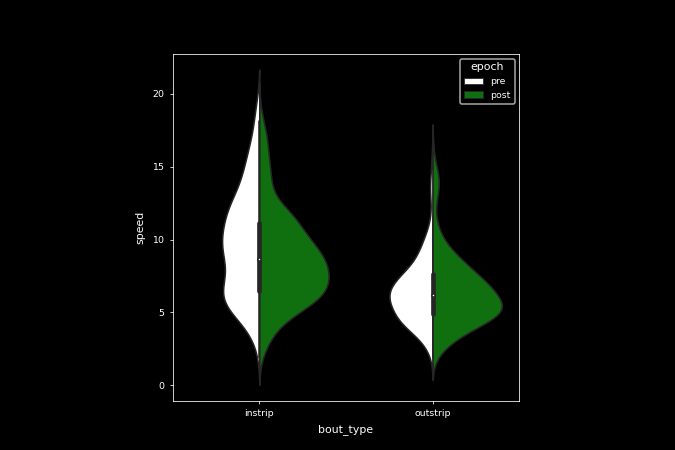

In [513]:
fig, ax= pl.subplots()
#ax.set_facecolor('w')
vplot = sns.violinplot(data=plotdf, x="bout_type", y=varn, hue="epoch", order=['instrip', 'outstrip'], palette=epoch_palette, split=True, ax=ax, 
              scale="count", linewidth=1, linecolor='w')
ax.set_box_aspect(1)
#ax.collections[0].set_edgecolor('white')
#ax.get_children()[5].set_color('w')  # <------------- changes the colour of the sticks
#ax.get_children()[6].set_color('w')  # <------------- changes the colour of the box


<IPython.core.display.Javascript object>


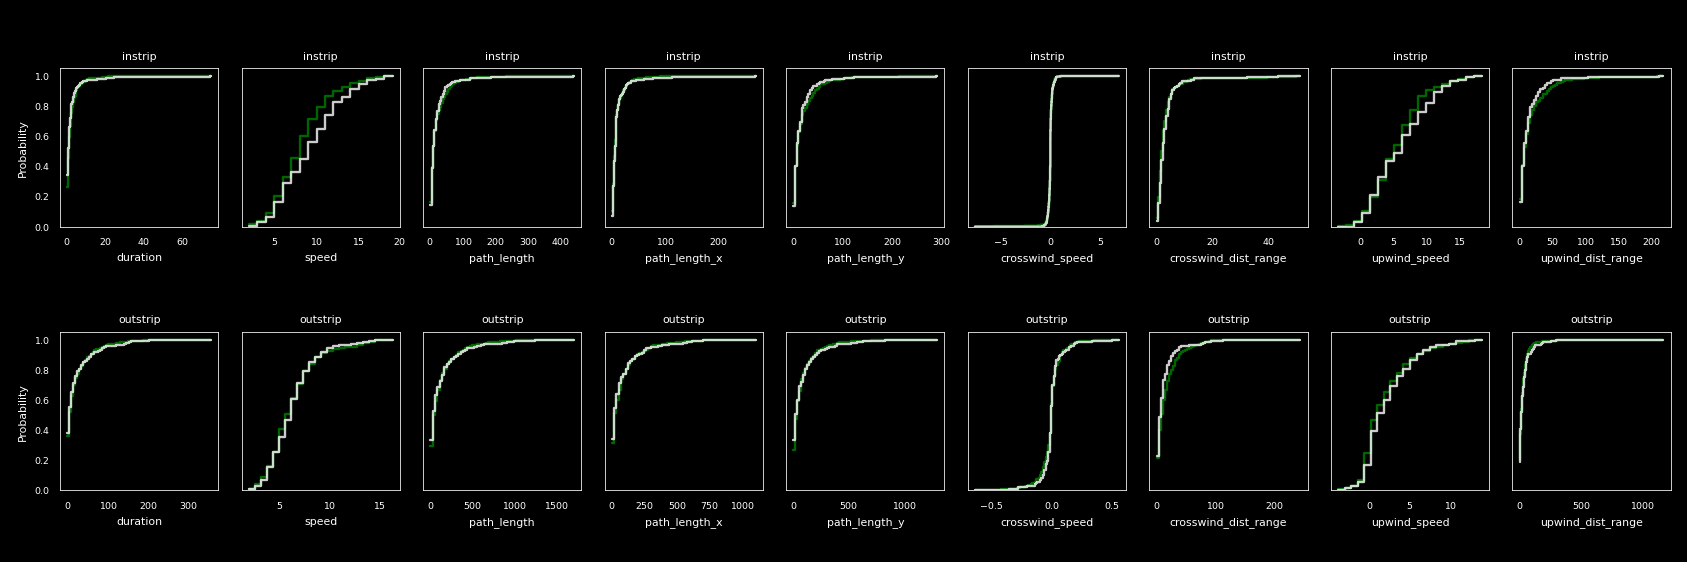

In [542]:
fig, axn = pl.subplots(2, len(plotvars), figsize=(15,5), sharex=False, sharey=True)
for ri, (bout_type, df_) in enumerate(plotdf.groupby('bout_type')):
    for ci, varn in enumerate(plotvars):
        ax=axn[ri, ci]
        sns.histplot(data=df_, x=varn, hue='epoch', palette=epoch_palette, ax=ax, alpha=0.8, fill=False,
                    cumulative=True, common_norm=False, stat='probability', element='step', kde=False)
        ax.set_title(bout_type)
        ax.legend_.remove()
        ax.set_box_aspect(1)
pl.tight_layout()

In [543]:
# plot_vars = ['crosswind_dist_range', 'speed', 'upwind_speed']
# for varn in plotvars:
#     fig, axn = pl.subplots(1, 2)
#     #ax.set_facecolor('w')
#     vmin, vmax = plotdf[varn].min(), plotdf[plotvar].max()
#     for bout_type, df_ in plotdf.groupby('bout_type'):
#         ax=axn[0] if bout_type=='instrip' else axn[1]
#         bins = np.linspace(vmin, vmax, nbins) #vals.min(), vals.max(), 200)
#         #ax2.hist(vals, bins, facecolor=col, edgecolor='none',  alpha=0.9, )
#         sns.histplot(data=df_, x=varn, hue='epoch', palette=epoch_palette, ax=ax, alpha=0.8, fill=False,
#                     cumulative=True, common_norm=False, stat='probability', element='step', kde=True)
#         ax.set_title(bout_type)
#         ax.set_box_aspect(1)

In [932]:
multi_block

['11152021-160015_PAMGTACR1_Fly2_006',
 '11162021-104332_PAMGTACR1_Fly1_001',
 '11162021-105012_PAMGtACR1_Fly1_002',
 '11182021-123116_PAMGtACR1_Fly1_001',
 '20230312-142945_PAM_activation_fly4-PAM-GtACR1-2do-fastedvF_000',
 '20230312-162127_PAM_activation_fly5-PAM-GtACR1-2do-fastedF_002',
 '20230312-170057_PAM_activation_fly6-PAM-GtACR1-2do-fastedF_000']

In [933]:

len(multi_block)

7

<IPython.core.display.Javascript object>


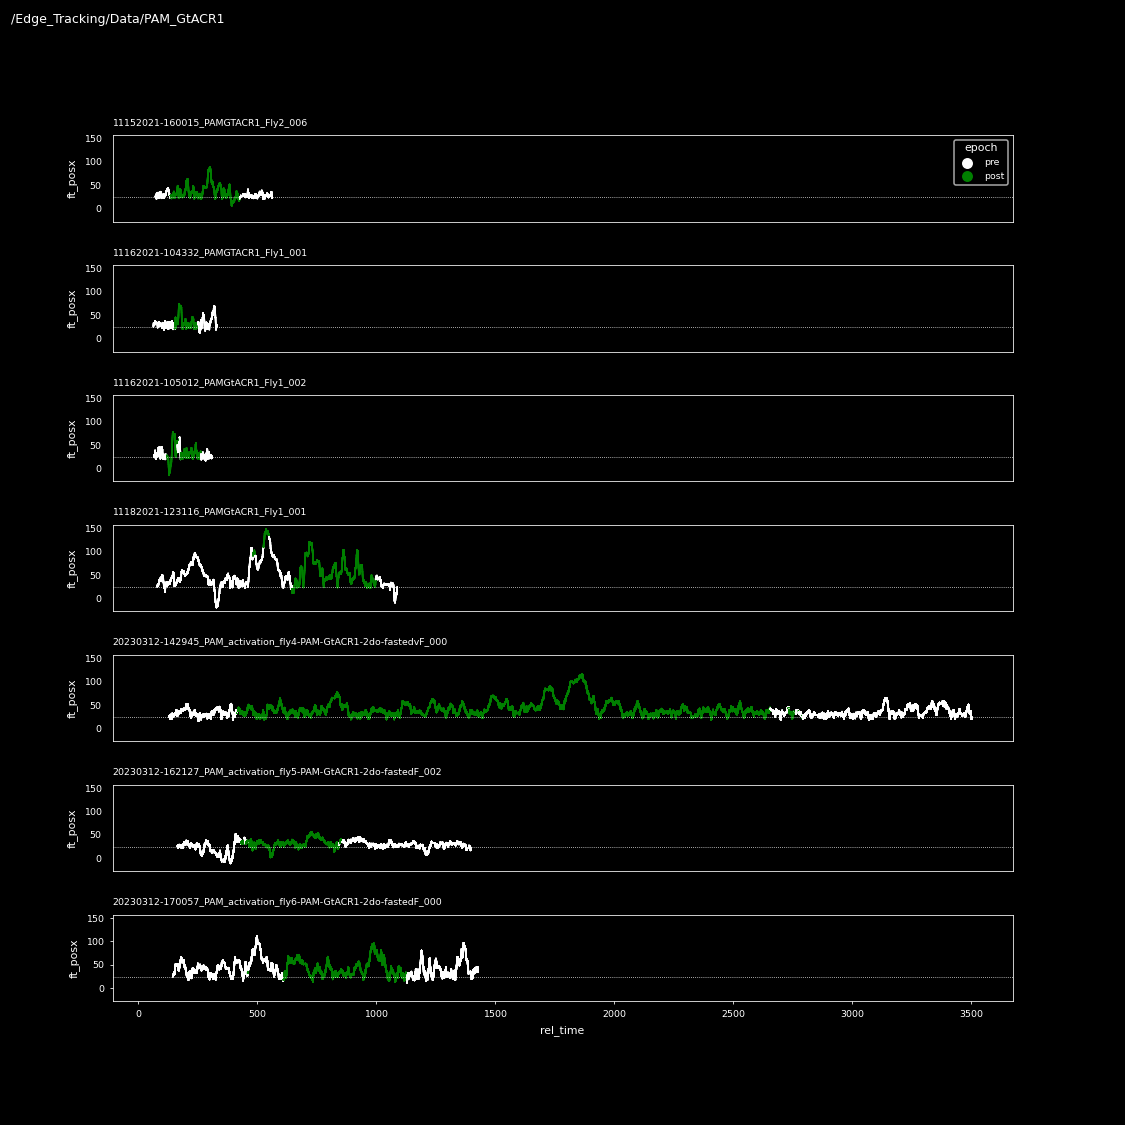

3 62
3 64
3 68
3 44
3 198
3 118
3 110
/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/ets


In [956]:
xvar = 'rel_time'
yvar = 'ft_posx'

fig, axn = pl.subplots(len(multi_block), 1, figsize=(10,10), sharex=True, sharey=True)

for fi, (fn, df_) in enumerate(etdf_multi.groupby('filename')):
    ax = axn.flat[fi]
    df_ = putil.zero_trajectory(df_)
    first_ = df_[df_['instrip']]['boutnum'].min() + 1
    last_ = df_[df_['instrip']]['boutnum'].max()
    print(first_, last_)
    currdf = df_[(df_['boutnum']>=first_) & (df_['boutnum'] <= last_) ].copy()
    currdf['dist_from_edge'] = currdf['ft_posx'] - 25
    currdf['dist_from_edge_abs'] = abs(currdf['dist_from_edge'])    
    
    sns.scatterplot(data=currdf[currdf['ft_posy']<=1500], x=xvar, y=yvar, hue='epoch', ax=ax,
                   linewidth=0.5, edgecolor='none', s=1, palette=epoch_palette)
    if fi != 0:
        ax.legend_.remove()
    ax.set_title(fn, loc='left', fontsize=6)
    if yvar=='ft_posx':
        yline = 25
    else:
        yline = 0
    ax.axhline(y=yline, lw=0.5, linestyle=':', color='w')
pl.subplots_adjust(left=0.1, right=0.9, hspace=0.5)

util.label_figure(fig, fig_id)
pl.savefig(os.path.join(curr_figdir, 'vs-time_{}.png'.format(yvar)))
print(curr_figdir)

In [960]:

df_z = [putil.zero_trajectory(df_) for fn, df_ in etdf_multi.groupby('filename')]
etdf_multi_zero = pd.concat(df_z).reset_index(drop=True)
    

<IPython.core.display.Javascript object>


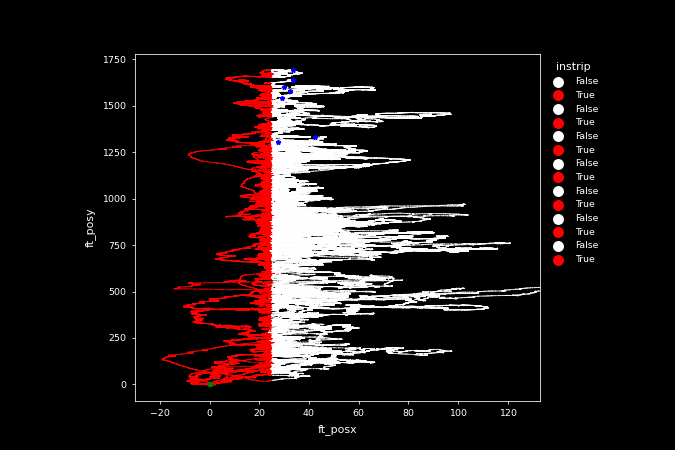

In [1011]:
fig, ax = pl.subplots()

for fn, df_ in etdf_multi_zero.groupby('filename'):
    butil.plot_trajectory(df_, ax=ax)
ax.

In [1013]:
(-20 - 25) + 25


-20

In [1058]:
etdf_multi_zero['dist_from_edge'] = etdf_multi_zero['ft_posx'] - 25
etdf_multi_zero['dist_from_edge_abs'] = abs(etdf_multi_zero['dist_from_edge'])
etdf_multi_zero.loc[etdf_multi_zero['instrip'], 'dist_from_edge_abs'] = (25 - etdf_multi_zero.loc[etdf_multi_zero['instrip'], 'ft_posx']) 
# abs( etdf_multi_zero['ft_posx'] ) - 25

In [1059]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [1060]:
boutdf_multi = butil.get_bout_metrics(etdf_multi_zero) #etdf_2blocks)
print(boutdf_multi.shape)
boutdf_multi_filt = traj.filter_first_instrip_last_outstrip(boutdf_multi)

(664, 37)
(650, 37)


/home/julianarhee/Repositories/plume-tracking/behavior.py:2805: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  'strip_type',


In [1061]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

In [1062]:
vars_to_flip = ['duration', 'speed_abs', 'path_length', 
                'path_length_x', 'path_length_y', 'crosswind_dist_range', 
                'upwind_speed_abs', 'upwind_dist_range', 'crosswind_speed_abs',
                'max_dist_from_edge', 'min_dist_from_edge', 'max_dist_from_edge_abs', 'min_dist_from_edge_abs']
boutdf_multi_filt = putil.flip_data_for_abutting_hists(boutdf_multi_filt, vars_to_flip=vars_to_flip)

In [1071]:
boutdf_multi_filt.groupby(['filename', 'instrip'])['max_dist_from_edge'].min()

filename                                                         instrip
11152021-160015_PAMGTACR1_Fly2_006                               False      0.460667
                                                                 True      -0.203320
11162021-104332_PAMGTACR1_Fly1_001                               False      2.236718
                                                                 True      -0.303395
11162021-105012_PAMGtACR1_Fly1_002                               False      2.706496
                                                                 True       0.140513
11182021-123116_PAMGtACR1_Fly1_001                               False      1.348022
                                                                 True      -0.381721
20230312-142945_PAM_activation_fly4-PAM-GtACR1-2do-fastedvF_000  False      0.158273
                                                                 True      -0.099064
20230312-162127_PAM_activation_fly5-PAM-GtACR1-2do-fastedF_002   False      0

In [1066]:
minv_in, maxv_in = etdf_multi_zero[etdf_multi_zero['instrip']]['ft_posx'].min(), etdf_multi_zero[etdf_multi_zero['instrip']]['ft_posx'].max()
minv_out, maxv_out = etdf_multi_zero[~etdf_multi_zero['instrip']]['ft_posx'].min(), etdf_multi_zero[~etdf_multi_zero['instrip']]['ft_posx'].max()
print("IN strip: max/min xpos is {:.2f}, {:.2f}".format(minv_in, maxv_in))
print("OUT strip: max/min xpos is {:.2f}, {:.2f}".format(minv_out, maxv_out))


IN strip: max/min xpos is -19.06, 26.43
OUT strip: max/min xpos is 22.92, 148.83


In [1067]:
xvar='dist_from_edge_abs'
minv_in, maxv_in = etdf_multi_zero[etdf_multi_zero['instrip']][xvar].min(), etdf_multi_zero[etdf_multi_zero['instrip']][xvar].max()
minv_out, maxv_out = etdf_multi_zero[~etdf_multi_zero['instrip']][xvar].min(), etdf_multi_zero[~etdf_multi_zero['instrip']][xvar].max()
print("IN strip: max/min {} is {:.2f}, {:.2f}".format(xvar, minv_in, maxv_in))
print("OUT strip: max/min {} is {:.2f}, {:.2f}".format(xvar, minv_out, maxv_out))


IN strip: max/min dist_from_edge_abs is -1.43, 44.06
OUT strip: max/min dist_from_edge_abs is 0.00, 123.83


/tmp/ipykernel_911331/3707070250.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  med_vals = plotdf.groupby(['instrip', 'epoch']).median().reset_index()


<IPython.core.display.Javascript object>


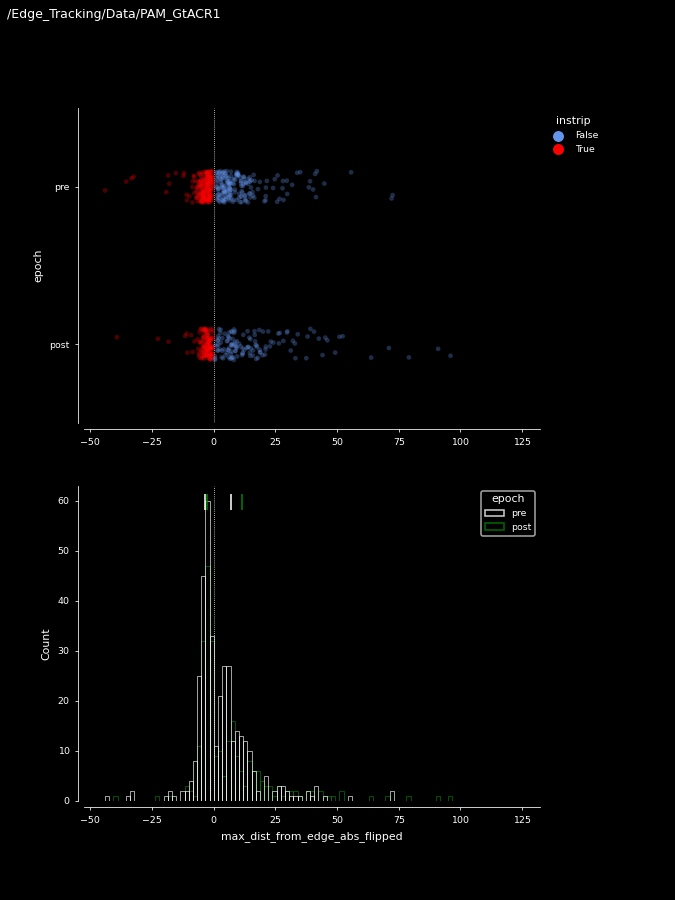

In [1076]:
varn = 'max_dist_from_edge_abs'
offset=1
plotdf = boutdf_multi_filt.copy()
estimator='median'
# -----------------------------------------------
plotvar = '{}_abs_flipped'.format(varn) if 'speed' in varn else '{}_flipped'.format(varn)
nbins = 20 if varn=='path length' else 100 #if 

plotdf = putil.flip_data_for_abutting_hists(plotdf, offset=offset)

if estimator=='median':
    med_vals = plotdf.groupby(['instrip', 'epoch']).median().reset_index()
else:
    med_vals = plotdf.groupby(['instrip', 'epoch']).mean().reset_index()

fig = pl.figure(figsize=(6,8)) # sharex=True)
gs = mpl.gridspec.GridSpec(2,1, figure=fig )
# create sub plots as grid
ax1 = fig.add_subplot(gs[0:1])
ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
               direction='out', left=True, bottom=True)
sns.stripplot(data=plotdf, x=plotvar, ax=ax1, 
            y='epoch', order=['ledoff', 'ledon'], s=3,
            hue='instrip', palette=instrip_palette, edgecolor='none', dodge=False,
            alpha=0.3)
ax1.set_xlabel('')
sns.move_legend(ax1, loc='upper left', bbox_to_anchor=(1,1), frameon=False)

ax2 = fig.add_subplot(gs[1], sharex=ax1)
# histogram underneath
vmin, vmax = plotdf[plotvar].min(), plotdf[plotvar].max()
for col, (cond, df_) in zip(['w','r'], plotdf.groupby('instrip')):
    vals = df_[plotvar].values
    bins = np.linspace(vmin, vmax, nbins) #vals.min(), vals.max(), 200)
    sns.histplot(data=df_, bins=bins, x=plotvar, hue='epoch', palette=epoch_palette, ax=ax2, alpha=0.8, fill=False)
# plot medians
for (is_instrip, epoch), mv in med_vals.groupby(['instrip', 'epoch']): 
    ylim = ax2.get_ylim()[-1]*0.95
    ax2.plot(float(mv[plotvar]), ylim, marker='|', color=epoch_palette[epoch], markersize=10)

# ticks
for ax in fig.axes:
    ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
                   direction='out', left=True, bottom=True)
    for pos in ['right', 'top']:
       ax.spines[pos].set_visible(False)
    ax.axvline(x=0, linestyle=':', lw=0.5, color='w')
    
sns.move_legend(ax2, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax2.set_ylabel('number of bouts')

sns.despine(offset=4)
pl.subplots_adjust(right=0.8)
util.label_figure(fig, fig_id)

pl.savefig(os.path.join(curr_figdir, 'sortedhist_{}.png'.format(varn)))


In [545]:
#bins = np.arange(bmin, bmax, 10)
bins = np.linspace(0, 1, 10)
bin_labels = [round(i, 2) for i in bins[1:]]

#bin_labels_5 = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']
boutdf_long['binned_boutnum'] = pd.qcut(boutdf_long['boutnum'],
                              bins, #[0, .2, .4, .6, .8, 1],
                              labels=bin_labels) #bin_labels_5)
bin_lut = {}
for bl in bin_labels:
    bin_lut[bl] = boutdf_long[boutdf_long['binned_boutnum']==bl]['boutnum'].median()
eff_palette = {'in': 'mediumorchid', 'out': 'green'}

In [412]:
fig, ax= pl.subplots()
    ax.plot(float(mv[plotvar]), ylim, marker='*', color=epoch_palette[epoch], markersize=50)


171.57

In [389]:
float(mv[plotvar])


11.180234394423998

In [386]:
med_vals = plotdf.groupby(['instrip', 'epoch']).median().reset_index()
med_vals[(med_vals['instrip']==)]

/tmp/ipykernel_911331/2518665548.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plotdf.groupby(['instrip', 'epoch']).median().reset_index()


,instrip,epoch,duration,upwind_dist_range,upwind_dist_firstlast,crosswind_dist_range,crosswind_dist_firstlast,path_length,path_length_x,path_length_y,...,crosswind_speed_abs,duration_flipped,speed_abs_flipped,path_length_flipped,path_length_x_flipped,path_length_y_flipped,crosswind_dist_range_flipped,upwind_speed_abs_flipped,upwind_dist_range_flipped,crosswind_speed_abs_flipped
0,False,post,8.907455,19.906223,9.275428,10.180234,0.001582,56.635273,33.363897,39.887058,...,0.029821,9.907455,7.038729,57.635273,34.363897,40.887058,11.180234,2.534675,20.906223,1.029821
1,False,pre,7.723622,21.533820,16.327795,7.610692,0.002912,52.326435,30.689706,36.301095,...,0.022472,8.723622,7.236421,53.326435,31.689706,37.301095,8.610692,3.052962,22.533820,1.022472
2,True,post,1.482289,8.688104,8.405114,2.408688,0.012473,13.125608,6.248746,9.957567,...,0.063315,-2.482289,-9.291795,-14.125608,-7.248746,-10.957567,-3.408688,-6.673391,-9.688104,-1.063315
3,True,pre,1.202347,7.953515,7.621158,2.597674,-0.000495,11.423750,5.901151,8.680086,...,0.068345,-2.202347,-10.769879,-12.423750,-6.901151,-9.680086,-3.597674,-7.522761,-8.953515,-1.068345


In [377]:
plotvar, plotdf[~plotdf['instrip']][plotvar].min(), plotdf[~plotdf['instrip']][plotvar].max()
new_logfiles

('crosswind_dist_range_flipped', 2.1537056004007096, 245.676509794781)

<IPython.core.display.Javascript object>


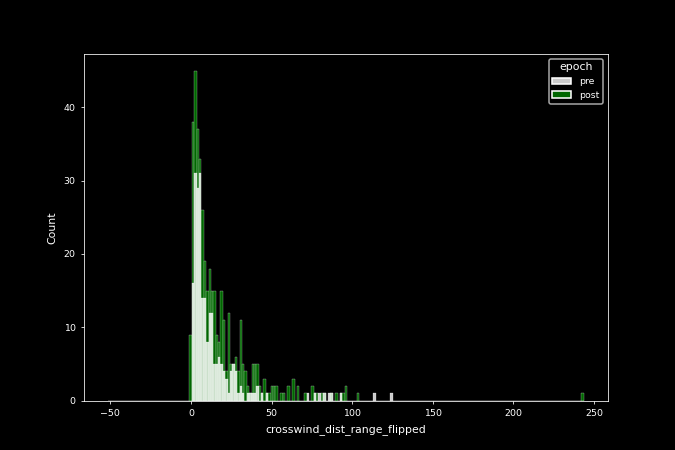

<AxesSubplot: xlabel='crosswind_dist_range_flipped', ylabel='Count'>

In [372]:
#for col, (cond, df_) in zip(['w','r'], plotdf.groupby('instrip')):
fig, ax =pl.subplots()
df_ = plotdf[~plotdf['instrip']]
#for epoch, edf_ in df_.groupby('epoch'):
vals = df_[plotvar].values
bins = np.linspace(vmin, vmax, nbins) #vals.min(), vals.max(), 200)
#ax2.hist(vals, bins, facecolor=col, edgecolor='none',  alpha=0.9, )
sns.histplot(data=df_, bins=bins, x=plotvar, hue='epoch', palette=epoch_palette, ax=ax, alpha=0.8)